# Let's Begin

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as pl
import matplotlib.colors as mc
import matplotlib.collections as mcoll
from scipy.interpolate import NearestNDInterpolator
from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from coords import *
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
from astropy.coordinates import Angle
import astropy.units as u
import cmasher as cmr


import lmfit
from lmfit import minimize, Parameters,create_params
from matplotlib.collections import LineCollection


from collections import Counter
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors


In [58]:
plt.style.use('classic')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

    

def rotate(x,y,theta):
    xprime = x*cos(theta) - y*sin(theta)
    yprime = x*sin(theta) + y*cos(theta)
    return xprime, yprime

l_offset = np.radians(-0.0558)
b_offset = np.radians(-0.0462)
x_offset = Rsun*l_offset
y_offset = Rsun*b_offset

#############################
# create class that stores a ring
#############################

class Ring:

    def __init__(self,t,a,bb,z,v0,theta,xyzsun,vxyzsun,alpha=0.4):
        self.t     = t
        self.a     = a
        self.bb     = bb
        self.z0    = z
        self.v0    = v0
        self.theta = theta
        self.x     = a*cos(t)
        self.y     = -bb*sin(t)
        self.z     = self.z0*sin(-2*t + alpha)
        self.R     = sqrt(self.x**2+self.y**2)
        self.phi   = -arctan2(self.y,self.x)
        self.ephix = -sin(self.phi) # unit vector parallel to circle
        self.ephiy = -cos(self.phi) # unit vector parallel to circle
        norm       = sqrt((a*sin(t))**2+(bb*cos(t))**2)
        self.ex    = -a*sin(t)/norm # unit vector parellel to ellipse
        self.ey    = -bb*cos(t)/norm  # unit vector parallel to ellipse
        self.cosalpha = self.ex*self.ephix + self.ey*self.ephiy
        self.vphi  = self.R[0]*self.v0/self.R # assume conservation of angular momentum
        self.v     = self.vphi/self.cosalpha # total speed along the orbit
        self.vx    = +self.v*self.ex
        self.vy    = +self.v*self.ey
        self.vz    = np.zeros(t.size)
        self.x,self.y   = rotate(self.x,self.y,theta)
        self.vx,self.vy = rotate(self.vx,self.vy,theta)
        self.X,self.Y,self.Z,self.vX,self.Vy,self.vZ = xyz2XYZ(self.x,self.y,self.z,self.vx,self.vy,self.vz,xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        # Convert Sgr A* offset from degrees to radians
        l_offset = np.radians(0.0558)
        b_offset = np.radians(-0.0462)
        x_offset = Rsun*l_offset
        y_offset = 0
        z_offset = Rsun*b_offset
        # Calculate galactic coordinates accounting for Sgr A* offset
        self.l,self.b,self.r,self.vl,self.vb,self.vr = xyz2lbr(
            self.x,self.y,self.z,self.vx,self.vy,self.vz,
            xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        self.l += l_offset
        self.b += b_offset
        self.x += x_offset
        self.y += y_offset
        self.z += z_offset
        self.mu_l, self.mu_b = vlb_2_mulb(self.r, self.vl*100, self.vb*100)
        self.mu_l, self.mu_b = vlb_2_mulb(self.r,self.vl*100,self.vb*100)

        
#############################
# define sun position & velocity
#############################

xsun  = 0.0
ysun  = -8.2
zsun  = 0.0
vxsun = -2.2
vysun = 0.0
vzsun = 0.0
xyzsun  = [xsun, ysun, zsun ]
vxyzsun = [vxsun,vysun,vzsun]
phisun  = arctan2(ysun,xsun)



In [59]:
def lb_lv_plots(Rings):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))


    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    


    ### Plot Rings LB ###
    ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_cat_agg)):
        
        if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            alpha = 0.5
        else:
            marker = 'o'
            alpha =1.

        if plot_cat_agg['NF_decision'][i] == 'N':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[0], s=120 , alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'LN':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[1], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'U':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[2], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'LF':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[3], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'F':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[4], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.1)


    ### Plot Rings LV ###
    ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_tab)):
        
        if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
            marker = 'X'
            alpha = 0.5
        else:
            marker = 'o'
            alpha = 1.

        if plot_tab['NF_decision'][i] == 'N':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[0], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'LN':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[1], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'U':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[2], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'LF':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[3], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'F':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[4], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)






    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    
    ax[0].text(.9, 1.10, 'a = {:.3f}, b = {:.3f}, z = {:.3f}, v0 = {:.2f}, theta_deg = {:.1f}, red_chisq = {:.2f}'.format(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),out.redchi), fontsize=15, ha='right', va='top', 
            transform=ax[0].transAxes)
    
    
    plt.show()

    return 

In [60]:
def lb_lv_plots_postcolor(Rings,out):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))


    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    


    ### Plot Rings LB ###
    ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)


    divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
    #cmap    = cmr.redshift_r
    cmap    = 'bwr_r'
    for i in range(0,len(plot_cat_agg)):

        if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha =1.
            

        if plot_cat_agg['NF_decision'][i] != 'nan':
            sc = ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, 
                           c=plot_post_tab_agg['mu_MC'][i], s=120, 
                           cmap=cmap, norm=divnorm, alpha = alpha)

        if plot_cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.1)



    ### Plot Rings LV ###
    ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_tab)):
        
        if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha = 1.

        if plot_tab['NF_decision'][i] != 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, 
                      c=plot_post_tab['mu_MC'][i], s=120, 
                      cmap=cmap, norm=divnorm, alpha = alpha)


        if plot_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    cax = fig.add_axes([0.15, 0.97, 0.73, 0.03])
    cb = plt.colorbar(sc, ax=ax[0], orientation='horizontal', cax=cax)   
    ax[0].text(.9, 1.4, 'a = {:.3f}, b = {:.3f}, z = {:.3f}, v0 = {:.2f}, theta_deg = {:.1f}, red_chisq = {:.2f}'.format(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),out.redchi), fontsize=15, ha='right', va='top', 
            transform=ax[0].transAxes)
    
    
    plt.show()

    return 

In [61]:
def load_data(path, sep='\s+', cols=[0,1,2,3],names=['l', 'b', 'v', 'near_far']):
    return pd.read_csv(path, sep=sep, header=None, names=names)
    #lk, bk, vk, NF = data['l'].values, data['b'].values, data['v'].values, data['near_far'].values
    #return data, lk, bk, vk, NF
    #Find near and far point

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_86436/157986325.py:1: SyntaxWarning: invalid escape sequence '\s'
  def load_data(path, sep='\s+', cols=[0,1,2,3],names=['l', 'b', 'v', 'near_far']):


In [62]:
### create a function that is a continuous distribution between NF on the ring itself
# take the y indices of the ring that are in front of the offset = Near; behind = Far
# values are relative weights in the distribution?
def ring_NF_dist_y(Rings):
    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<y_offset)

    y_NF =  Rings.y.copy()
    y_NF=np.where(Rings.y<y_offset,y_NF,-(Rings.y - np.nanmin(Rings.y[back_ind]) )/ (np.nanmax(Rings.y[back_ind]) - np.nanmin(Rings.y[back_ind])))
    y_NF=np.where(Rings.y>=y_offset,y_NF,(Rings.y - np.nanmin(Rings.y[fore_ind]) )/ (np.nanmax(Rings.y[fore_ind]) - np.nanmin(Rings.y[fore_ind])))
    #y_NF=np.where(Rings.y<y_offset,y_NF,-1)
    #y_NF=np.where(Rings.y>=y_offset,y_NF,1)

    return back_ind, fore_ind, y_NF


def ring_NF_dist(Rings):
    back_ind = np.where(Rings.r>=8.2)
    fore_ind = np.where(Rings.r<8.2)

    y_NF =  Rings.r.copy()
    y_NF[back_ind] = -(Rings.r[back_ind] - 8.2 )/ (np.nanmax(Rings.r[back_ind]) - 8.2)
    y_NF[fore_ind] =  1-(Rings.r[fore_ind] - np.nanmin(Rings.r[fore_ind]) )/ (8.2 - np.nanmin(Rings.r[fore_ind]))
    #y_NF=np.where(Rings.y<y_offset,y_NF,-1)
    #y_NF=np.where(Rings.y>=y_offset,y_NF,1)

    return back_ind, fore_ind, y_NF

def calculate_mahalanobis_distances(data, model):
    cov = np.cov(data.T) 
    inv_cov = np.linalg.inv(cov)
    distances = cdist(data, model, metric='mahalanobis', VI=inv_cov)
    return distances, inv_cov


def min_distance_mahalanobis(data, model):

    # compute distances for every point on the stream
    dist, inv_cov = calculate_mahalanobis_distances(data, model)

    # find the minima 
    glob_min_idxs =[]
    for i in range(len(data)):
        glob_min_idxs.append(np.argwhere(dist[i]==np.min(dist[i])).ravel()[0])
    return glob_min_idxs, dist #returns all distance values and minima index

def normalizelbv(l,b,v):
    lmin, lmax = -0.6, 1.7
    bmin, bmax = -0.3, 0.1
    vmin, vmax = -110., 100.
    
    #using approximate extents of the data in l,b,v to normalize between -1 and 1
    norml = 2*((l - lmin) / (lmax - lmin)) -1. 
    normb = 2*((b - bmin) / (bmax - bmin)) -1. 
    normv = 2*((v - vmin) / (vmax - vmin)) -1. 
    
    return norml,normb,normv

def distancelbv(l, b, v, l0, b0, v0):
    #typical Cartesian distance measurement 
    d_l = l - l0
    d_b = b - b0
    d_v = v - v0
    dis = np.sqrt( d_l**2 + d_b**2 + d_v**2)
    return dis


def min_distancelbv(streaml, streamb, streamv, P):
    """
    Compute minimum/a distance/s between
    a point P[x0,y0,z0] and a curve (x,y,z).
    
    Returns min indexes and distances array.
    """
    # compute distances for every point on the stream
    d = distancelbv(streaml, streamb, streamv, P[0], P[1], P[2])

    # find the minima 
    glob_min_idxs = np.argwhere(d==np.min(d)).ravel()
    return glob_min_idxs, d #returns all distance values and minima index


#Gaussian function for the PPDF distributions (used in KNN search)
def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2.* (sigma**2 )))

#Save normed data as a class
class norm_data:    
    def __init__(self, norml0, normb0, normv0, NF):
        self.l0 = norml0
        self.b0 = normb0
        self.v0 = normv0
        self.NF = NF #Cloud NF is decided from the PPDF centers, already normalized to [-1,1]

In [63]:
def normedr_to_pc(r, A):
    '''takes in a normalized LOS position, r in (-1,1) scaling, 
    as well as a normalization constant A (in pc) that corresponds to the radius of the ellipse.
    returns top-down y value for distance from SgrA* in PARSECS
    
    y < 0 in NEAR, y>0 is FAR
    
    '''
    
    return A*r

# LMFIT time

In [319]:
###Read in data to scatter plot in lbv 
cat_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
post_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex")

##remove the rows with NaN NF decisions 
non_fitting_rows = list(np.where(cat_tab['NF_decision']=='nan')[0])
pixel_masked_rows =  np.where(cat_tab['lb_pixel_mask']==0)[0]

for i in pixel_masked_rows:
    if i not in non_fitting_rows:
        non_fitting_rows.append(i)

#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='12')[0][0]))

non_fitting_rows.append((np.where(cat_tab['leaf_id']=='10')[0][0]))
non_fitting_rows.append((np.where(cat_tab['leaf_id']=='9')[0][0]))
non_fitting_rows.append((np.where(cat_tab['leaf_id']=='13')[0][0]))
non_fitting_rows.append((np.where(cat_tab['leaf_id']=='14')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='8b')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='8c')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='11b')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='11c')[0][0]))

post_tab.remove_rows(non_fitting_rows)
cat_tab.remove_rows(non_fitting_rows)

cat_index = cat_tab['leaf_id']
cloud_name = cat_tab['cloud_name']
NF_decision = cat_tab['NF_decision']
lb_pixel_mask = cat_tab['lb_pixel_mask']

post_A = post_tab['A_MC']
post_mu = post_tab['mu_MC']
post_sigma = post_tab['sigma_MC']



## aggregate table that pulls out the largest mask
## to represent the l,b N/F/U position

cat_group = cat_tab.group_by('lb_pixel_mask')
cat_group_mask = cat_group.groups.keys['lb_pixel_mask'] == 1

cat_agg = cat_group.groups[cat_group_mask]


## For plotting only
plot_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
plot_cat_group = plot_tab.group_by('lb_pixel_mask')
plot_cat_group_mask = plot_cat_group.groups.keys['lb_pixel_mask'] == 1
plot_cat_agg = plot_cat_group.groups[plot_cat_group_mask]
plot_post_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex")
plot_post_tab_agg = plot_post_tab[np.where(plot_tab['lb_pixel_mask']==1)]



In [320]:
####################################################
### Pre-process the DATA to normalize to [-1,1] ###
####################################################
norml0, normb0, normv0 = normalizelbv(cat_tab['l'],cat_tab['b'], cat_tab['v'])
Ndata = norm_data(norml0, normb0, normv0, post_mu)

In [321]:
params = create_params(a_rings={'value': 0.09   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.055  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 25  , 'min': 0, 'max': 180, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                          )

params_OFF = create_params(a_rings={'value': 0.1   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.1  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 110.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 30  , 'min': 15, 'max': 360, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                          )

params_dphi = create_params(a_rings={'value': 0.09   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.055  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 25  , 'min': 0, 'max': 180, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': True}
                          )

In [67]:
#############################
###Uncertainty of fitting?###
#############################
# Store the y-axis top-down values of all of the pc LOS distances 
# from each iteration of the fitting for each cloud.
# Then we'll make a histogram of the various distances for each cloud,
# and get the uncertainties in pc?



In [322]:


def ring_resid(params, l,b,v):
    
    a_rings=params['a_rings']
    b_rings=params['b_rings']
    z_rings=params['z_rings']
    v_rings=params['v_rings']
    theta_rings=params['theta_rings']
    ddphi=params['ddphi']
    
    dphi = np.radians(ddphi)
    phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
    
    Rings = Ring(phi,a_rings,b_rings,z_rings,v_rings, np.radians(theta_rings),xyzsun,vxyzsun)
            
    ### Pre-process the given MODEL; normalize to [-1,1] ###
    normELL_l, normELL_b, normELL_v = normalizelbv(np.degrees(Rings.l),np.degrees(Rings.b),Rings.vr)
    back_ind, fore_ind, y_NF = ring_NF_dist_y(Rings) #finds the N/F on the ellipse
    Nrings = norm_data(normELL_l, normELL_b, normELL_v , y_NF)
    
    
    ### Perform KNN search on the model and find the neighbor distances and indices in the model
    nn = NearestNeighbors(n_neighbors=int(np.sqrt(len(Nrings.l0))), metric='minkowski')
    nn.fit(np.vstack([Nrings.l0,Nrings.b0,Nrings.v0,Nrings.NF]).T)
    distances, indices = nn.kneighbors(np.vstack([Ndata.l0,Ndata.b0,Ndata.v0,Ndata.NF]).T)
    
    
    ### for each catalogue point, find the minimum residual between pt and the ellipse
    #   and save the min to array
    min_d_list = []
    nf_penalty_list = [] #saves how closely the nearest point matches the NF position posterior based on KNN search
    
    model_data = np.vstack([Nrings.l0,Nrings.b0,Nrings.v0]).T
    cat_data = np.vstack([Ndata.l0,Ndata.b0,Ndata.v0]).T
    glob_min_idxs, dist_lbv = min_distance_mahalanobis(cat_data,model_data)
    
    cat_los_i = [] #list for values of LOS in parsec for each cloud
    
    for i in range(len(cat_tab)):

        ### store min distance into the min dist list ###
        min_d_list.append(dist_lbv[i][glob_min_idxs[i]])
        
        
        
        ### Find how well each point agrees with the N/F degree of the model ellipse ###
        
        idx=indices[i]
        dist = distances[i]
        neighbors_nf = Nrings.NF[idx]
        common_nf = Counter(neighbors_nf).most_common(1)[0][0]
        post_dist_value = gaussian(common_nf ,post_A[i],post_mu[i],post_sigma[i])


        nf_penalty = post_A[i] - post_dist_value #this fits by seeing how close the point is to the peak on the posterior curve
        #nf_penalty = post_mu[i] - common_nf #this fits by comparing how offset the point is from the center of the gaussian
        nf_penalty_list.append(abs(nf_penalty))  


    lists_of_lists = [min_d_list, nf_penalty_list]
    resid_list = [sum(x) for x in zip(*lists_of_lists)] #add the values of the lists together

    return resid_list
    

In [323]:

out = minimize(ring_resid, params, method='nelder', args=(Ndata.l0,Ndata.b0,Ndata.v0))



In [324]:
out

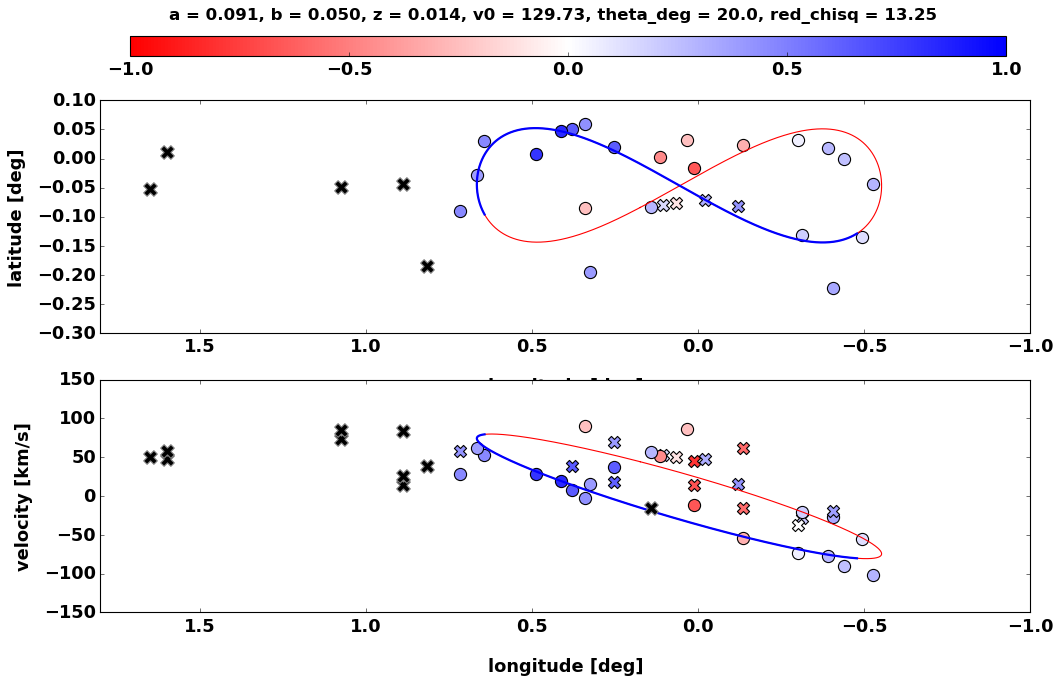

In [ ]:
dphi = np.radians(0.001)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)

Rings_out = Ring(phi,
                  out.params['a_rings'].value,
                  out.params['b_rings'].value,
                  out.params['z_rings'].value,
                  out.params['v_rings'].value, 
                  np.radians(out.params['theta_rings'].value),
                  xyzsun,vxyzsun)

'''Rings_out = Ring(phi,
                  0.091,
                  0.050,
                  0.014,
                  129.73, 
                  np.radians(20.0),
                  xyzsun,vxyzsun)'''

'''
Rings_out_off = Ring(phi,
                  out_off.params['a_rings'].value,
                  out_off.params['b_rings'].value,
                  out_off.params['z_rings'].value,
                  out_off.params['v_rings'].value, 
                  np.radians(out_off.params['theta_rings'].value),
                  xyzsun,vxyzsun)'''

lb_lv_plots_postcolor(Rings_out, out)
#lb_lv_plots_postcolor(Rings_out_off, out_off)

#Save output to dat files
list(vars(Rings_out).items())

save_Rings_out = Table()
Rings_out_fit_params = Table()

for i in list(vars(Rings_out).items()):
    if type(i[1])!=np.float64:
        save_Rings_out[i[0]] = i[1]
    if type(i[1])==np.float64:
        Rings_out_fit_params[i[0]] = [i[1]]
        
ascii.write(save_Rings_out, "/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/Rings_out.dat", overwrite=True)  
ascii.write(Rings_out_fit_params,"/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/Rings_out_params.dat", overwrite=True)


In [326]:
def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

In [327]:
def lb_lv_plots_postcolor_grad(Rings, out, output_save = 'None'):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))


    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    
    ringcmap = 'bwr_r' #cmr.prinsenvlag


    ### Plot Rings LB ###
    ringcolor = ring_NF_dist(Rings)[2]
    lines = colored_line(np.degrees(Rings.l),np.degrees(Rings.b), ringcolor, ax[0], linewidth=5, cmap=ringcmap,zorder=1)

    #ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    #ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)


    divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
    #cmap    = cmr.redshift_r
    cmap    = 'bwr_r'
    for i in range(0,len(plot_cat_agg)):

        if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha =1.
            

        if plot_cat_agg['NF_decision'][i] != 'nan':
            sc = ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, 
                           c=plot_post_tab_agg['mu_MC'][i], s=120, 
                           cmap=cmap, norm=divnorm, alpha = alpha)

        if plot_cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.1)



    ### Plot Rings LV ###
    ringcolor = ring_NF_dist(Rings)[2]
    lines = colored_line(np.degrees(Rings.l),Rings.vr, ringcolor, ax[1], linewidth=5, cmap=ringcmap,zorder=1)

    #ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    #ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_tab)):
        
        if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha = 1.

        if plot_tab['NF_decision'][i] != 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, 
                      c=plot_post_tab['mu_MC'][i], s=120, 
                      cmap=cmap, norm=divnorm, alpha = alpha)


        if plot_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    cax = fig.add_axes([0.15, 0.97, 0.73, 0.03])
    cb = plt.colorbar(sc, ax=ax[0], orientation='horizontal', cax=cax)   
    ax[0].text(.9, 1.4, 'a = {:.3f}, b = {:.3f}, z = {:.3f}, v0 = {:.2f}, theta_deg = {:.1f}, red_chisq = {:.2f}'.format(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),out.redchi), fontsize=15, ha='right', va='top', 
            transform=ax[0].transAxes)
    
    #cax2 = fig.add_axes([.97, 0.1, 0.03, 0.8])
    #cb2 = plt.colorbar(lines, orientation='vertical', cax=cax2)
    #cb2.set_label('Ring LOS N/F', rotation=270)

    if output_save != 'None':
        plt.savefig(output_save, bbox_inches='tight')   
    
    plt.show()





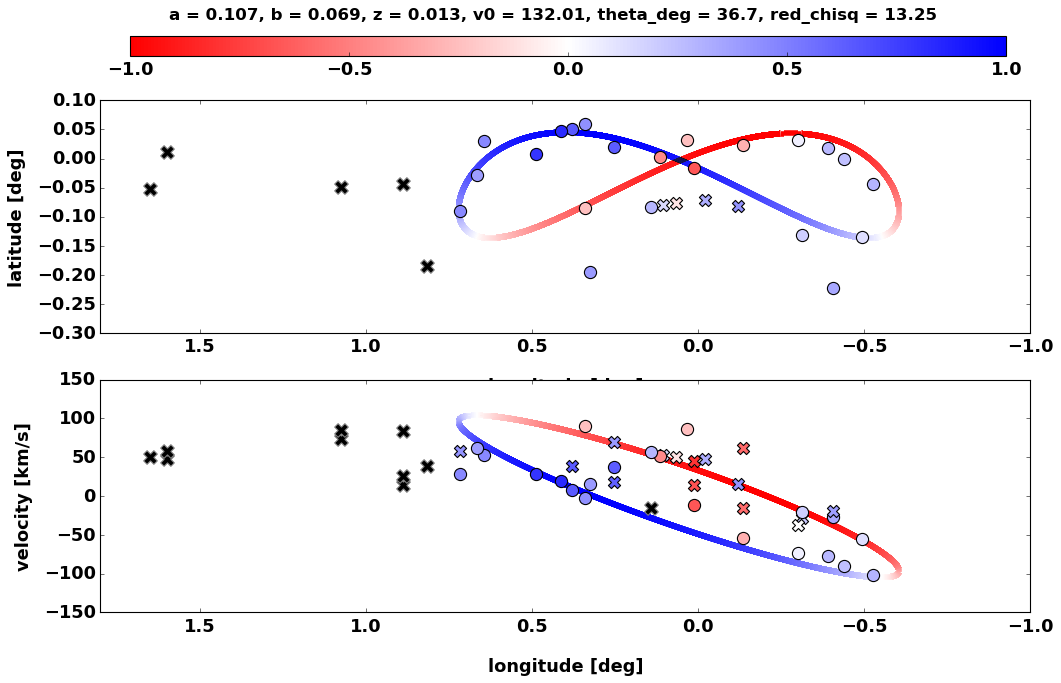

In [328]:

lb_lv_plots_postcolor_grad(Rings_out, out, output_save='./paper_items/Figs/paper3_ellipse_fit_output.pdf')
#lb_lv_plots_postcolor_grad(Rings_out_off, out_off)


# Top-down visualizations!

In [256]:
def denorm_yNF_value(y_NF, Rings_out):
        
    """This function takes in a normalized array (-1,1) and converts it to a top-down y-axis
    distance from SgrA* based on that output from the best fitting x2 ellipse (Rings_out).
    
    Negative values are on the NEAR SIDE in front of SgrA*
    Positive values are on the FAR SIDE behind SgrA*
    
    Results are in kiloparsecs!! 
    """
    
    term1 = (y_NF + 1)/2
    term2 = (np.nanmax(Rings_out.r) - np.nanmin(Rings_out.r))
    
    real_y = (term1*term2) + np.nanmin(Rings_out.r)

    #returns the LOS distance on the ring from SgrA* in kpc
    return real_y

def denorm_sigma_value(NFsigma, Rings_out):

    minkpc =  8.2 - np.nanmin(Rings_out.r)
    maxkpc =  8.2 - np.nanmax(Rings_out.r)
    widthkpc = minkpc - maxkpc
    
    term1 = (NFsigma)
    term2 = widthkpc - 0
    
    real_sig = (term1*term2) 

    #returns the LOS distance on the ring from SgrA* in kpc
    return real_sig




In [262]:
dphi = np.radians(0.001)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
Rings_inner = Ring(phi,
                  0.015,
                  0.010,
                  0.011,
                  128.00, 
                  np.radians(15.0),
                  xyzsun,vxyzsun)

Rings_avg = Ring(phi,
                  0.091,
                  0.050,
                  0.014,
                  129.73, 
                  np.radians(20.0),
                  xyzsun,vxyzsun)

Rings_outer = Ring(phi,
                  0.136,
                  0.103,
                  0.013,
                  131.0, 
                  np.radians(40.2),
                  xyzsun,vxyzsun)

In [370]:
(8.2-denorm_yNF_value(1.125,Rings_avg)) * 1000

np.float64(-63.475712928482864)

In [ ]:
##convert the cloud posterior sigmas into pc uncertainties for the plotted ones?

cat_sig_list = []
cat_y_list = []
for i in range(len(plot_post_tab_agg[:-3])):
    
    
    lowerlim_sig_kpc = denorm_sigma_value(plot_post_tab_agg['sigma_MC'][i], Rings_inner)
    avglim_sig_kpc   = denorm_sigma_value(plot_post_tab_agg['sigma_MC'][i], Rings_avg)
    upperlim_sig_kpc = denorm_sigma_value(plot_post_tab_agg['sigma_MC'][i], Rings_outer)
    
    #combinesig_kpc = np.sqrt(lowerlim_sig_kpc**2 + upperlim_sig_kpc**2)
    combinesig_kpc = (lowerlim_sig_kpc**2 + upperlim_sig_kpc**2 + avglim_sig_kpc**2)**(1./2.)
    
    cat_sig_list.append(combinesig_kpc)
    
    lowerlim_y = denorm_yNF_value(plot_post_tab_agg['mu_MC'][i],Rings_inner)
    avglim_y   = denorm_yNF_value(plot_post_tab_agg['mu_MC'][i],Rings_avg)
    upperlim_y = denorm_yNF_value(plot_post_tab_agg['mu_MC'][i],Rings_outer)
    
    #combiney_kpc = np.mean([lowerlim_y,  upperlim_y])
    combiney_kpc = np.mean([lowerlim_y,  upperlim_y, avglim_y])
    
    cat_y_list.append(8.2-combiney_kpc)
    
    print(plot_cat_agg['leaf_id'][i], combinesig_kpc, (8.2-combiney_kpc)*1e3  )
    
    

1 0.05105351457433915 -18.158466785767047
2 0.04667889268349364 -7.7716268773802
3 0.02518552018702887 -15.357041418200268
4a 0.06293637636971351 -20.954292443459366
5 0.026457749993095525 -16.883874070318328
6b 0.02331697756855654 -11.753887850373346
7a 0.0336876939755802 -3.7535187710595608
8a 0.034788258360630896 18.920648518170324
9 0.03569703635437796 -25.617609518134188
10 0.0871547943596585 -19.587435303176193
11a 0.05055861214481098 40.58588759913739
12 0.08633680441198398 15.2138191646074
13 0.0331559448888325 6.669520370978788
14 0.009453746599400233 -8.893652441868127
15 0.07498706264790445 27.917070194208193
16b 0.023429584730980158 -17.579478249427183
17b 0.022693025339309888 -39.37382774865661
18 0.1388624072069425 -24.53852807458823
19 0.043301086649382946 -26.80977558847175
20 0.08743567220011576 15.233978966604056
21a 0.021034017035135764 -39.7503381570079
22 0.014893112340859403 -51.14699821738711
23 0.027592014166978082 -48.801684958394986
24 0.031601049623151814 -28

In [ ]:
cat_sig_list[25]

In [ ]:
x_offset

In [259]:
def los_l_to_xyz(l):
    
    rr = np.linspace((8.2--0.159),(8.2-0.159), 100)
    x,y,z,vx,vy,vz=lbr2xyz(np.deg2rad(l),np.deg2rad(0),rr,
                       0,0,0,xsun=-8.2,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=2.2,vzsun=0.0)
    return -y , x

<>:62: SyntaxWarning: invalid escape sequence '\e'
<>:62: SyntaxWarning: invalid escape sequence '\c'
<>:62: SyntaxWarning: invalid escape sequence '\e'
<>:62: SyntaxWarning: invalid escape sequence '\c'
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_86436/1769871679.py:62: SyntaxWarning: invalid escape sequence '\e'
  ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_86436/1769871679.py:62: SyntaxWarning: invalid escape sequence '\c'
  ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_86436/1769871679.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_86436/1769871679.py:58: UserWarning: set_ticklabels() should only be used with a fixed number 

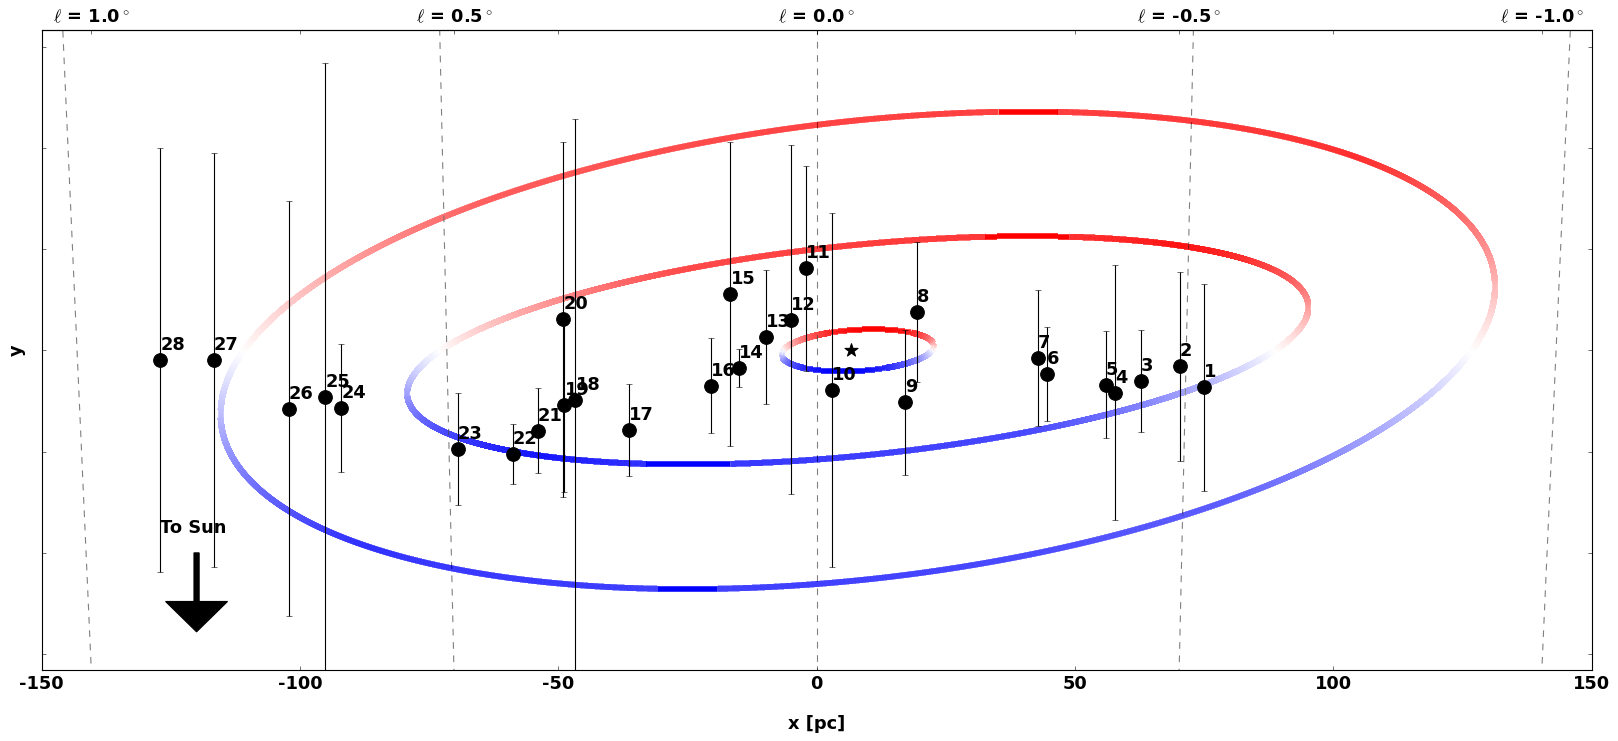

In [272]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 10))
fig.set_facecolor('white')
fig.set_facecolor('white')


ringcmap = 'bwr_r' #cmr.prinsenvlag


### Plot Rings LB ###
min_ringcolor = ring_NF_dist(Rings_inner)[2]
min_lines = colored_line(Rings_inner.x ,Rings_inner.y , min_ringcolor, ax, linewidth=5, cmap=ringcmap,zorder=10)


avg_ringcolor = ring_NF_dist(Rings_avg)[2]
avg_lines = colored_line(Rings_avg.x ,Rings_avg.y , avg_ringcolor, ax, linewidth=5, cmap=ringcmap,zorder=10)


max_ringcolor = ring_NF_dist(Rings_outer)[2]
max_lines = colored_line(Rings_outer.x ,Rings_outer.y , max_ringcolor, ax, linewidth=5, cmap=ringcmap,zorder=10)

sgra = ax.scatter(-y_offset , 0 , marker = '*', s=150 ,color = 'k',zorder=10)


long_list = np.arange(-1.5, 1.5, 0.5)
axt_ticks = []
for ll in long_list:
    xline, rrline = los_l_to_xyz(ll)
    ax.plot(xline, rrline , linestyle = '--', c='gray',zorder=0)
    axt_ticks.append(xline[-1])


for i in range(len(cat_y_list)):
    x,y,z,vx,vy,vz=lbr2xyz(np.deg2rad(plot_cat_agg['l'][i]),np.deg2rad(plot_cat_agg['b'][i]),cat_y_list[i]+8.2,
                       0,0,0,xsun=-8.2,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=2.2,vzsun=0.0)
    ax.scatter(-y,cat_y_list[i], marker = 'o', c='k' , s = 150, zorder = 10)
    ax.errorbar(-y,cat_y_list[i], yerr=cat_sig_list[i], fmt="o", c='k', zorder=10)
    #ax.text((-y),cat_y_list[i]+0.005, plot_cat_agg['leaf_id'][i])
    ax.text((-y),cat_y_list[i]+0.005, int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][i]))) , zorder=10) 
###create a gradient between the two rings

#polygon = ax.fill_between(Rings_out_off.x, Rings_out_off.y,color = 'none', edgecolor='none',zorder=1)
#ax.fill(Rings_out.x ,Rings_out.y,'white', edgecolor='none',zorder=2)
#verts = np.vstack([p.vertices for p in polygon.get_paths()])
#gradient = ax.imshow(np.linspace(0, 1, 256).reshape(1, -1), cmap=ringcmap, aspect='auto',
                     # extent=[verts[:, 1].min(), verts[:, 1].max(), verts[:, 0].min(), verts[:, 0].max()])
#gradient.set_clip_path(polygon.get_paths()[0], transform=ax.gca().transData)

ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.158, 0.158)

#ax.axes.get_yaxis().set_visible(False)

xlabels = [item.get_text().replace('\u2212', '-') for item in ax.get_xticklabels()]
xlabels = [str(int(float(item)*1e3)) for item in xlabels]
ylabels = [item.get_text().replace('\u2212', '-') for item in ax.get_yticklabels()]
ylabels = [str(int(float(item)*1e3)) for item in ylabels]
ax.set_xticklabels(xlabels)
ax.set_yticklabels(' ')

ax_t = ax.secondary_xaxis('top') #set top axis ticks on
ax_t.set_xticks(axt_ticks)
ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])

ax.set_xlabel('x [pc]', labelpad=20)
ax.set_ylabel('y', labelpad=10)

ax.arrow(-.120, -.100, 0, -0.008*3, length_includes_head=False,
          head_width=0.004*3, head_length=0.005*3, color = 'k')
ax.text(-.127, -.09, 'To Sun')



plt.savefig('./paper_items/Figs/x2_fits_topdown_ellipses.pdf', bbox_inches='tight')

In [275]:
cat_tab

<Table length=22>
leaf_id   cloud_name      l       b    ... NF_decision absorp_NF lb_pixel_mask
  str3      str14      float64 float64 ...     str3       str3       int64    
------- -------------- ------- ------- ... ----------- --------- -------------
      1 G359.475-0.044  -0.525  -0.044 ...          LN       nan             1
      2 G359.508-0.135  -0.492  -0.135 ...           N       nan             1
      3 G359.561-0.001  -0.439  -0.001 ...           U         F             1
     4a G359.595-0.223  -0.405  -0.223 ...           N       nan             1
      5 G359.608+0.018  -0.392   0.018 ...          LN         N             1
     6b G359.688-0.132  -0.312  -0.132 ...           U         F             1
     7a G359.701+0.032  -0.299   0.032 ...          LN         N             1
     8a G359.865+0.023  -0.135   0.023 ...           F         F             1
    11a   G0.014-0.016   0.014  -0.016 ...           F       nan             1
    ...            ...     ...     ... ...         ...       ...           ...
    17b    G0.255+0.02   0.255    0.02 ...           N         N             1
     18   G0.327-0.195   0.327  -0.195 ...           U       nan             1
     19    G0.342+0.06   0.342    0.06 ...           N         N             1
     20   G0.342-0.085   0.342  -0.085 ...           F         F             1
    21a    G0.379+0.05   0.379    0.05 ...           N         N             1
     22   G0.413+0.048   0.413   0.048 ...           N         N             1
     23   G0.488+0.008   0.488   0.008 ...           N         N             1
     24    G0.645+0.03   0.645    0.03 ...           N       nan             1
     25   G0.666-0.028   0.666  -0.028 ...           U         N             1
    26a    G0.716-0.09   0.716   -0.09 ...           N       nan             1

# Save LOS dist results to Table

In [283]:
##convert the cloud posterior sigmas into pc uncertainties for ALL IDs

full_cat_sig_list = []
full_cat_y_list = []
for i in range(len(plot_post_tab[:])):
    
    
    lowerlim_sig_kpc = denorm_sigma_value(plot_post_tab['sigma_MC'][i], Rings_inner)
    avglim_sig_kpc   = denorm_sigma_value(plot_post_tab['sigma_MC'][i], Rings_avg)
    upperlim_sig_kpc = denorm_sigma_value(plot_post_tab['sigma_MC'][i], Rings_outer)
    
    #combinesig_kpc = np.sqrt(lowerlim_sig_kpc**2 + upperlim_sig_kpc**2)
    combinesig_kpc = (lowerlim_sig_kpc**2 + upperlim_sig_kpc**2 + avglim_sig_kpc**2)**(1./2.)
    
    full_cat_sig_list.append(combinesig_kpc)
    
    lowerlim_y = denorm_yNF_value(plot_post_tab['mu_MC'][i],Rings_inner)
    avglim_y   = denorm_yNF_value(plot_post_tab['mu_MC'][i],Rings_avg)
    upperlim_y = denorm_yNF_value(plot_post_tab['mu_MC'][i],Rings_outer)
    
    #combiney_kpc = np.mean([lowerlim_y,  upperlim_y])
    combiney_kpc = np.mean([lowerlim_y,  upperlim_y, avglim_y])
    
    full_cat_y_list.append(8.2-combiney_kpc)
    
    print(plot_tab['leaf_id'][i], combinesig_kpc, (8.2-combiney_kpc)*1e3  )
    
    

1 0.05105351457433915 -18.158466785767047
2 0.04667889268349364 -7.7716268773802
3 0.02518552018702887 -15.357041418200268
4a 0.06293637636971351 -20.954292443459366
4b 0.08554226465109077 -23.31227831889926
5 0.026457749993095525 -16.883874070318328
6a 0.029050499676889566 -12.603333397079197
6b 0.02331697756855654 -11.753887850373346
7a 0.0336876939755802 -3.7535187710595608
7b 0.036737198452878546 -0.2694769923952123
8a 0.034788258360630896 18.920648518170324
8b 0.02721378512227684 35.23479918010608
8c 0.042155894633135085 35.90676584653707
9 0.03569703635437796 -25.617609518134188
10 0.0871547943596585 -19.587435303176193
11a 0.05055861214481098 40.58588759913739
11b 0.05265065408705692 48.85556553619885
11c 0.023587118415632224 41.35693126829487
12 0.08633680441198398 15.2138191646074
13 0.0331559448888325 6.669520370978788
14 0.009453746599400233 -8.893652441868127
15 0.07498706264790445 27.917070194208193
16a nan nan
16b 0.023429584730980158 -17.579478249427183
17a 0.02120250768

In [318]:
los_table = Table()
los_table['leaf id'] = plot_tab['leaf_id']
los_table['cloud name'] = plot_tab['cloud_name']
los_table['l'] = plot_tab['l'] * u.degree
los_table['b'] = plot_tab['b'] * u.degree
los_table['v'] = plot_tab['v'] * u.km/ u.s
los_table['A_mc']      = plot_post_tab['A_MC'].round(3)
los_table['mu_mc']     = plot_post_tab['mu_MC'].round(3)
los_table['sigma_mc']  = abs(plot_post_tab['sigma_MC'].round(3))
los_table['LOS_pos'] = np.round(np.array(full_cat_y_list), 3) * u.kpc
los_table['LOS_sig'] = np.round(np.array(full_cat_sig_list), 3) * u.kpc

los_table.write("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/LOS_synth_table.tex", format = 'latex', overwrite=True)


In [316]:
los_table[:10]

<Table length=10>
leaf id   cloud name      l       b    ...  mu_mc  sigma_mc LOS_pos LOS_sig
                         deg     deg   ...                    kpc     kpc  
  str3      str14      float64 float64 ... float64 float64  float64 float64
------- -------------- ------- ------- ... ------- -------- ------- -------
      1 G359.475-0.044  -0.525  -0.044 ...   0.294    0.195  -0.018   0.051
      2 G359.508-0.135  -0.492  -0.135 ...   0.125    0.178  -0.008   0.047
      3 G359.561-0.001  -0.439  -0.001 ...   0.249    0.096  -0.015   0.025
     4a G359.595-0.223  -0.405  -0.223 ...    0.34     0.24  -0.021   0.063
     4b G359.595-0.223  -0.405  -0.223 ...   0.378    0.326  -0.023   0.086
      5 G359.608+0.018  -0.392   0.018 ...   0.274    0.101  -0.017   0.026
     6a G359.688-0.132  -0.312  -0.132 ...   0.204    0.111  -0.013   0.029
     6b G359.688-0.132  -0.312  -0.132 ...    0.19    0.089  -0.012   0.023
     7a G359.701+0.032  -0.299   0.032 ...    0.06    0.129  -0.004   0.034
     7b G359.701+0.032  -0.299   0.032 ...   0.004     0.14    -0.0   0.037

In [ ]:
Rings_out_tab = ascii.read("Rings_out.dat")

def denorm_yNF_value(y_NF, Rings_out):
        
    """This function takes in a normalized array (-1,1) and converts it to a top-down y-axis
    distance from SgrA* based on that output from the best fitting x2 ellipse (Rings_out).
    
    Positive values are on the NEAR SIDE in front of SgrA*
    Negative values are on the FAR SIDE behind SgrA*
    
    Results are in kiloparsecs!! 
    """
    term1 = (y_NF + 1)/2
    term2 = (np.nanmax(Rings_out_tab['r']) - np.nanmin(Rings_out_tab['r']))
    
    real_y = (term1*term2) + np.nanmin(Rings_out_tab['r'])

    #returns the LOS distance on the ring from SgrA* in kpc
    return real_y

def argmedian(x):
    return np.argpartition(x, len(x) // 2)[len(x) // 2]
#normELL_l, normELL_b, normELL_v = normalizelbv(Rings_out.l,Rings_out.b,Rings_out.vr)
#back_ind, fore_ind, y_NF = ring_NF_dist(Rings_out) #finds the N/F on the ellipse
#Nrings = norm_data(normELL_l, normELL_b, normELL_v , y_NF)

# Try fitting different initial CMZ sizes (change by 5 pc each time?)

10 10
[-0.08844851] [-0.08824833]
[0.07859554] [0.03273751] [1.] [-1.]


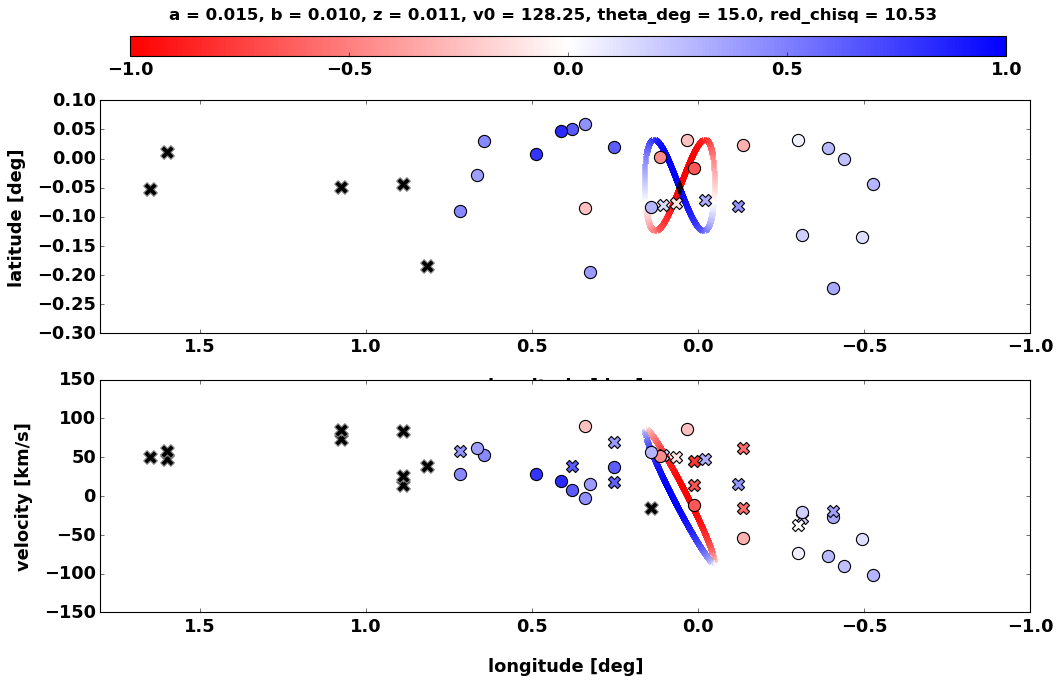

15 15
[-0.08614072] [-0.08470965]
[0.07896318] [0.03237293] [1.] [-1.]


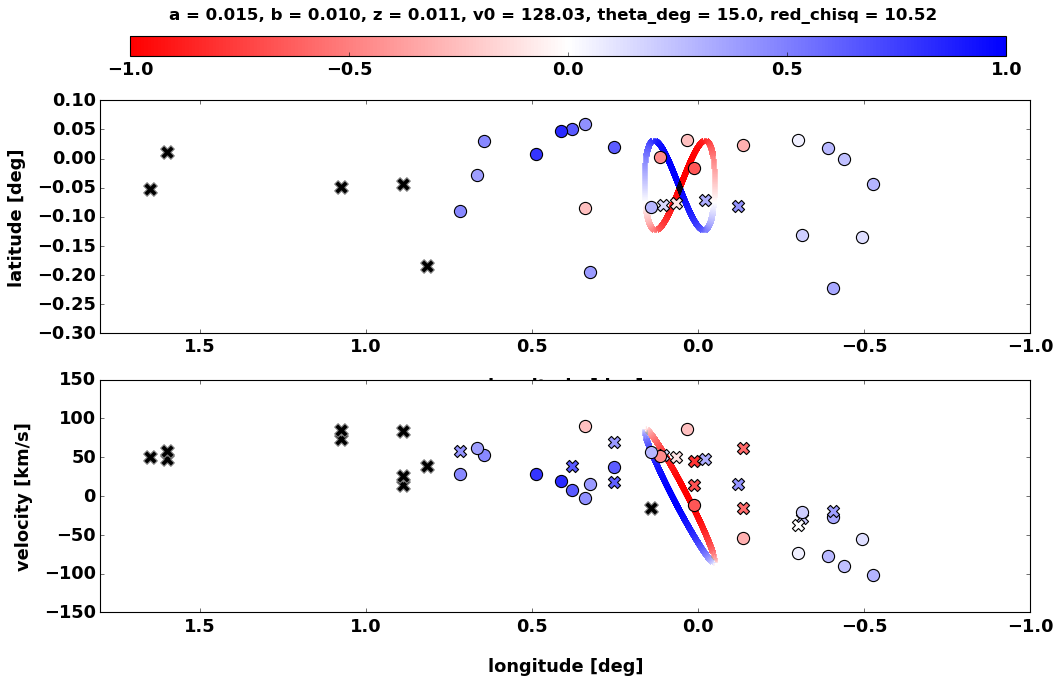

20 20
[-0.11224808] [-0.11377089]
[0.06608622] [0.04531952] [1.] [-1.]
25 25
[-0.08362095] [-0.0812397]
[0.08532021] [0.02598208] [1.] [-1.]


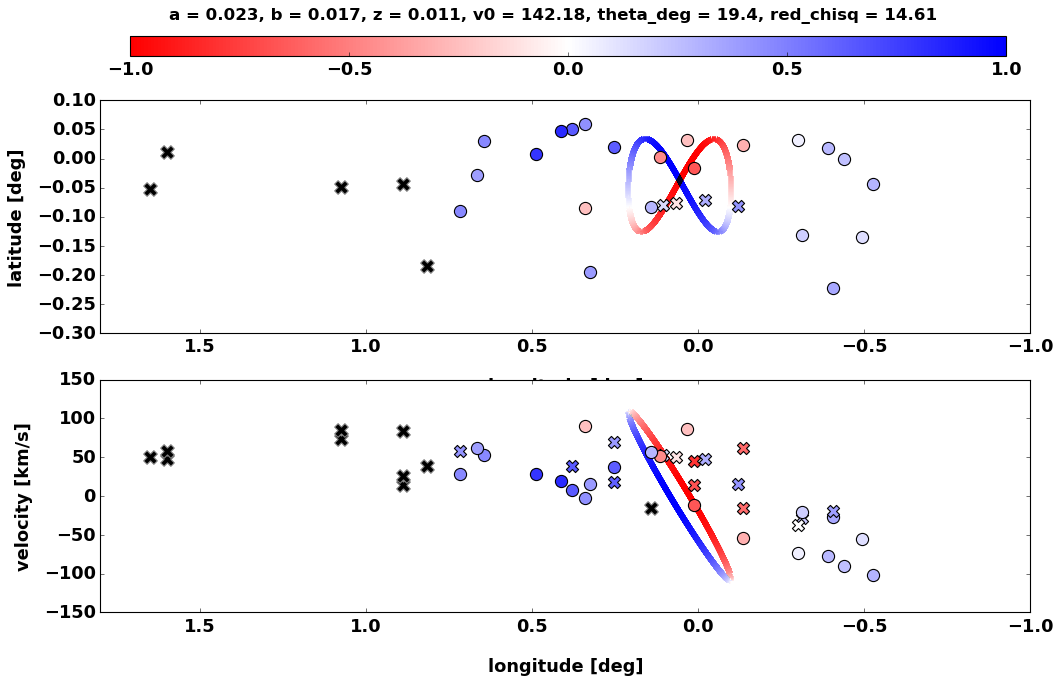

30 30
[-0.01849794] [-0.00200993]
[0.25941741] [-0.14799782] [1.] [-1.]


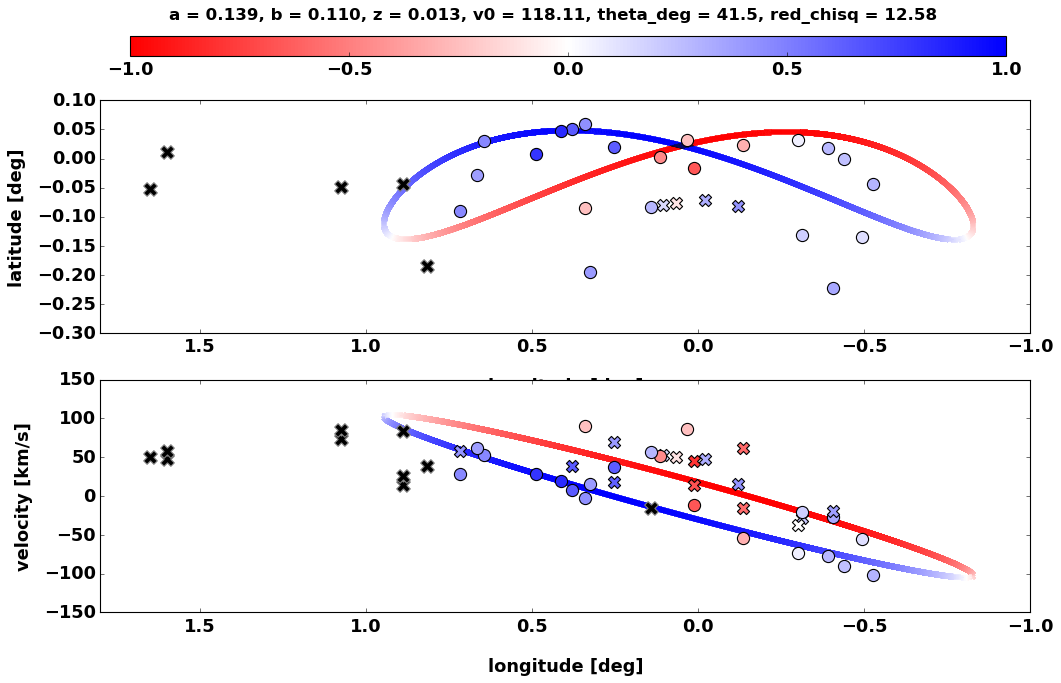

35 35
[-0.02216447] [-0.00140451]
[0.31104769] [-0.19981229] [1.] [-1.]


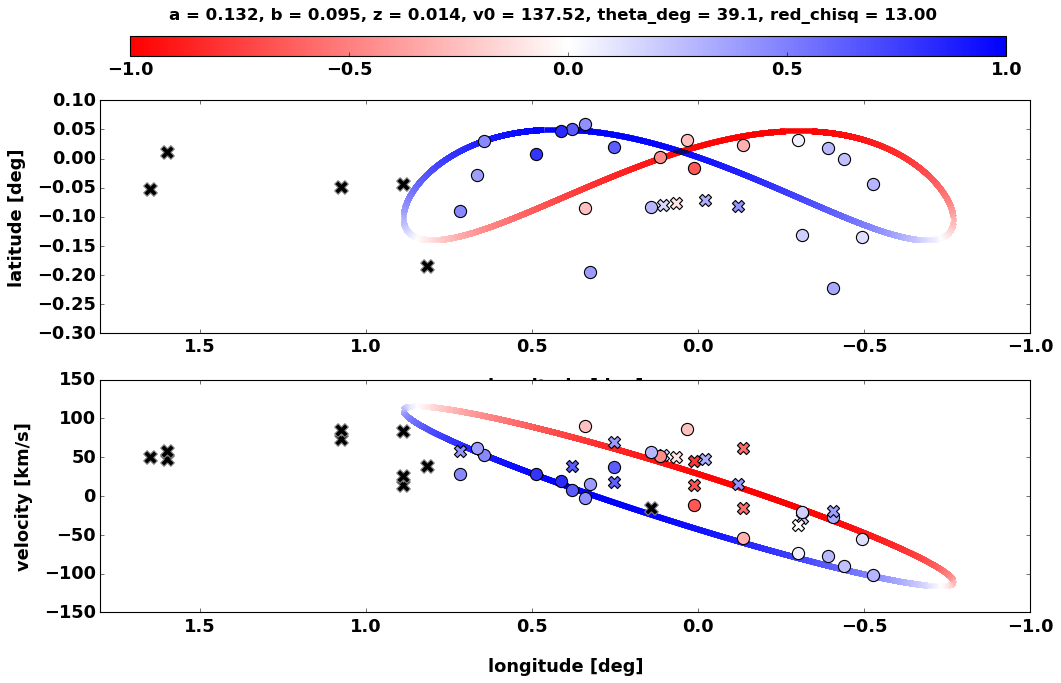

40 40
[-0.01775282] [-0.00059679]
[0.28122892] [-0.17103672] [1.] [-1.]


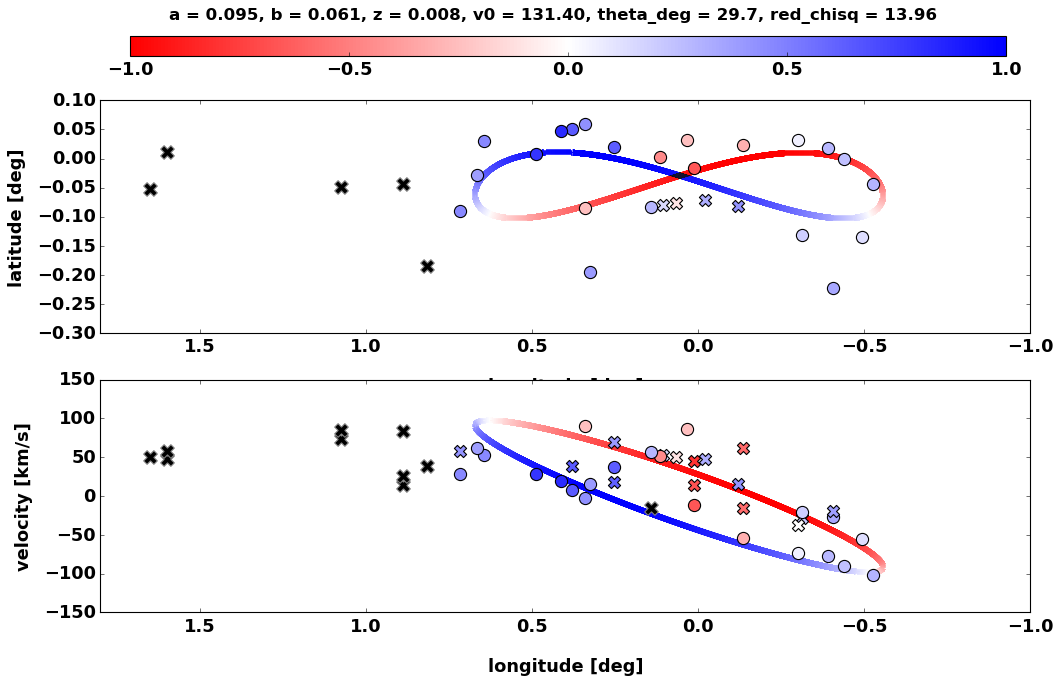

45 45
[-0.022052] [-0.00290525]
[0.28552805] [-0.17424431] [1.] [-1.]


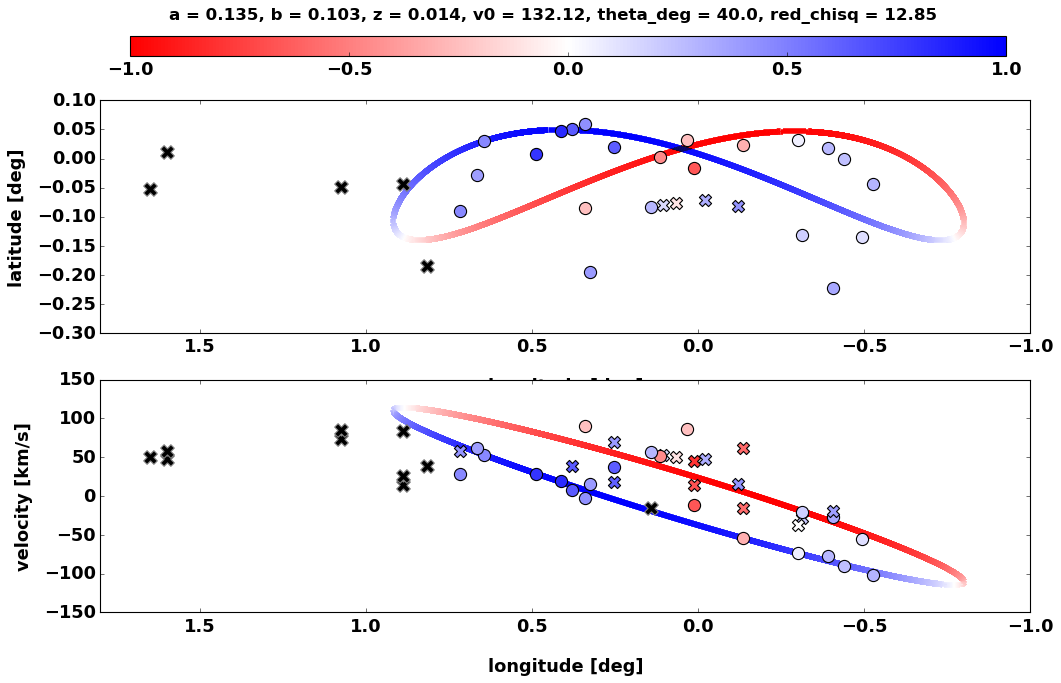

50 50
[-0.02631799] [-0.0069298]
[0.30990977] [-0.20005349] [1.] [-1.]


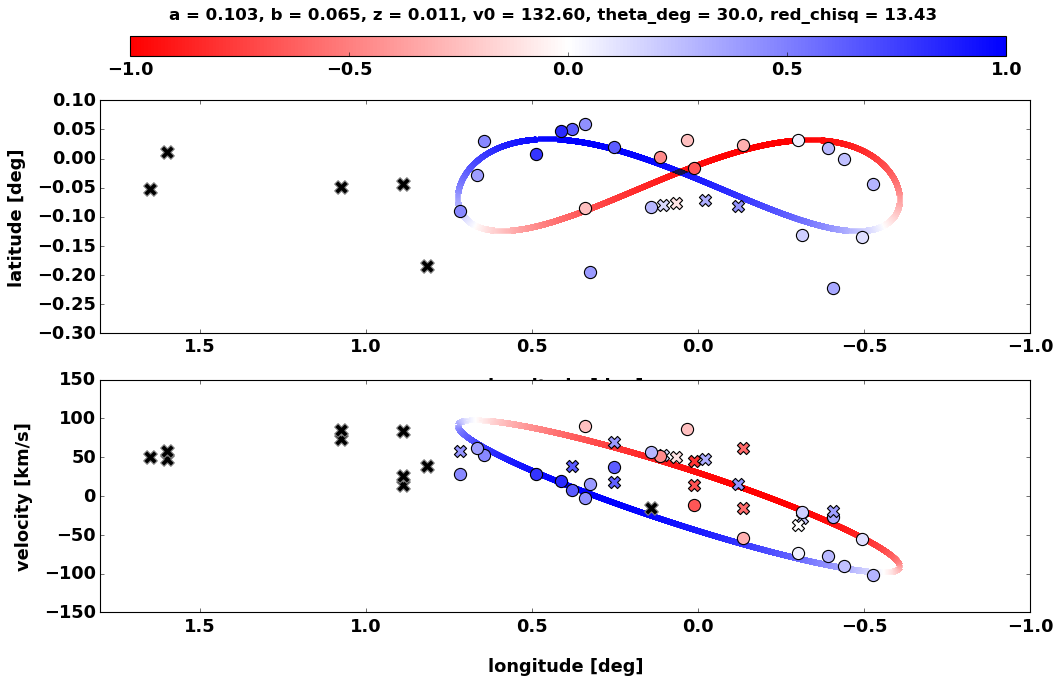

55 55
[-0.02580149] [-0.00668848]
[0.29720197] [-0.18779522] [1.] [-1.]


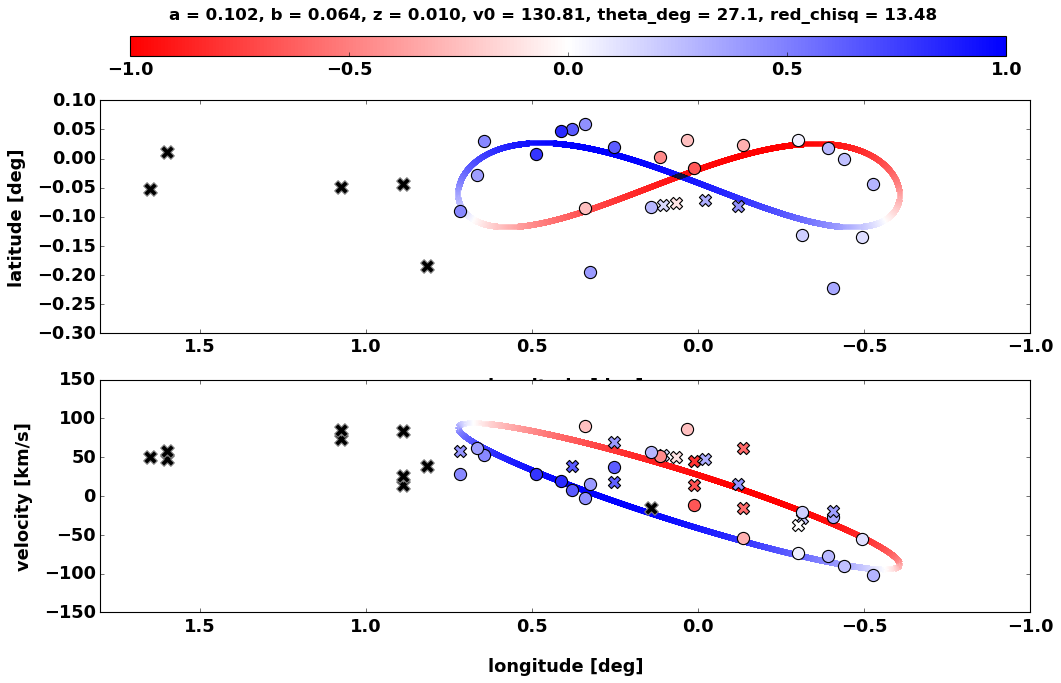

60 60
[-0.02243175] [-0.0023472]
[0.30974504] [-0.19920432] [1.] [-1.]


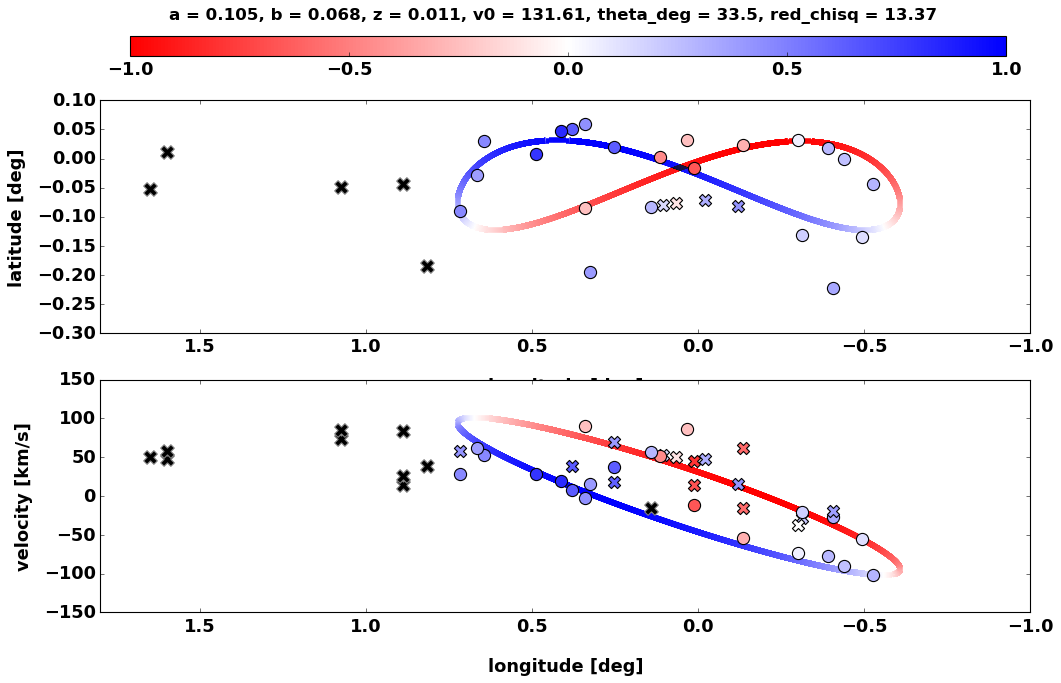

65 65
[-0.02304233] [-0.00323775]
[0.30031097] [-0.18979617] [1.] [-1.]


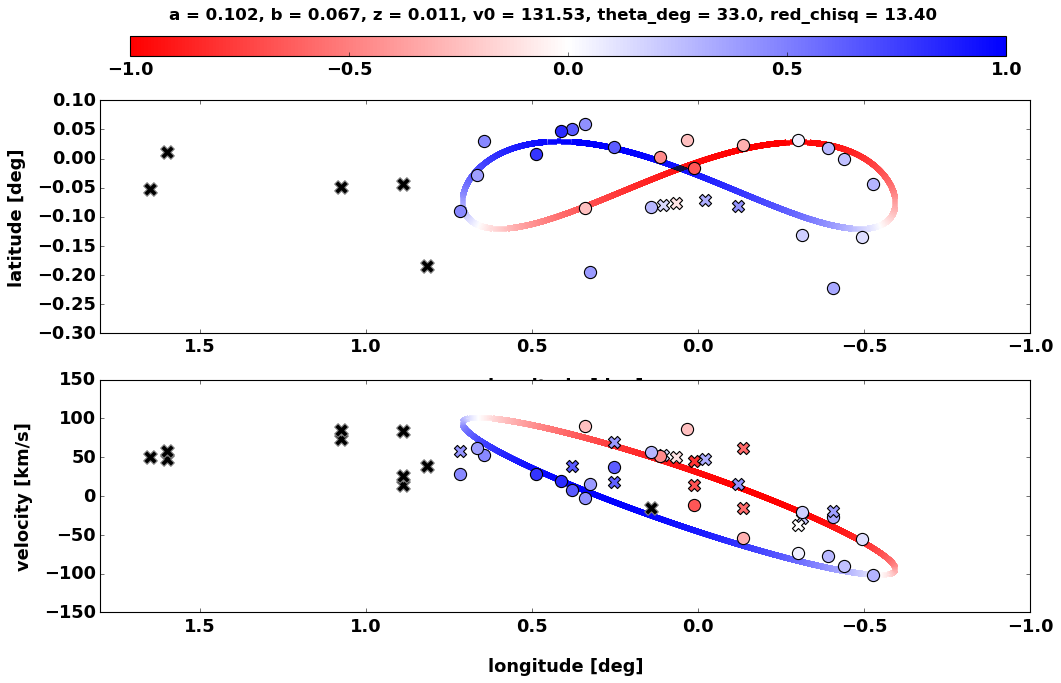

70 70
[-0.02322802] [-0.00366596]
[0.29885813] [-0.18861023] [1.] [-1.]


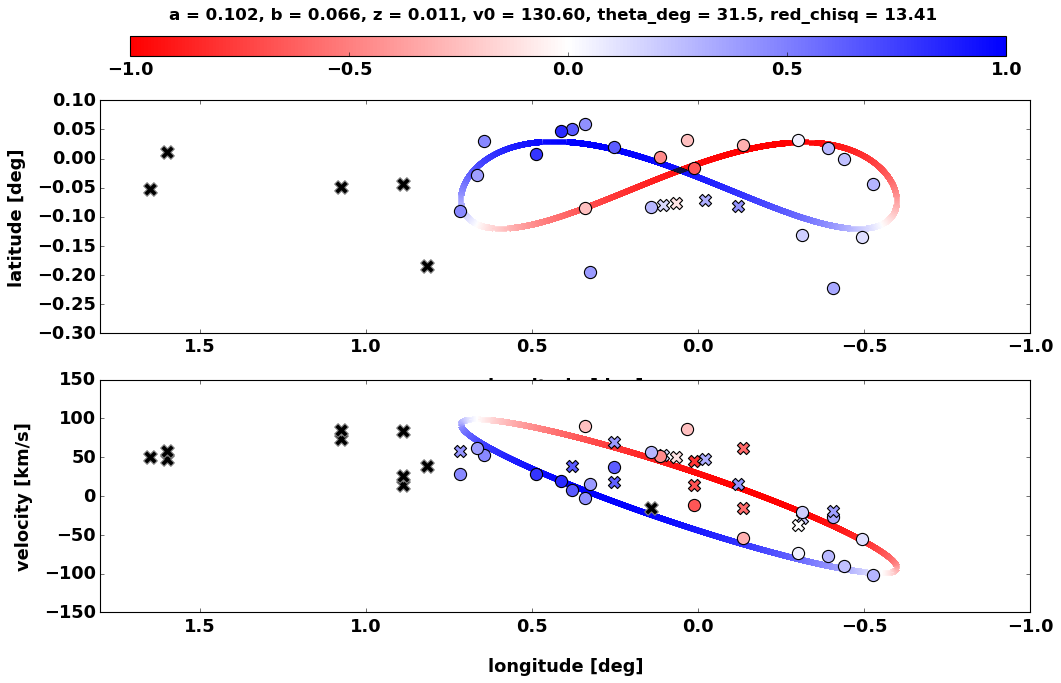

75 75
[-0.023039] [-0.00158929]
[0.31487922] [-0.20379881] [1.] [-1.]


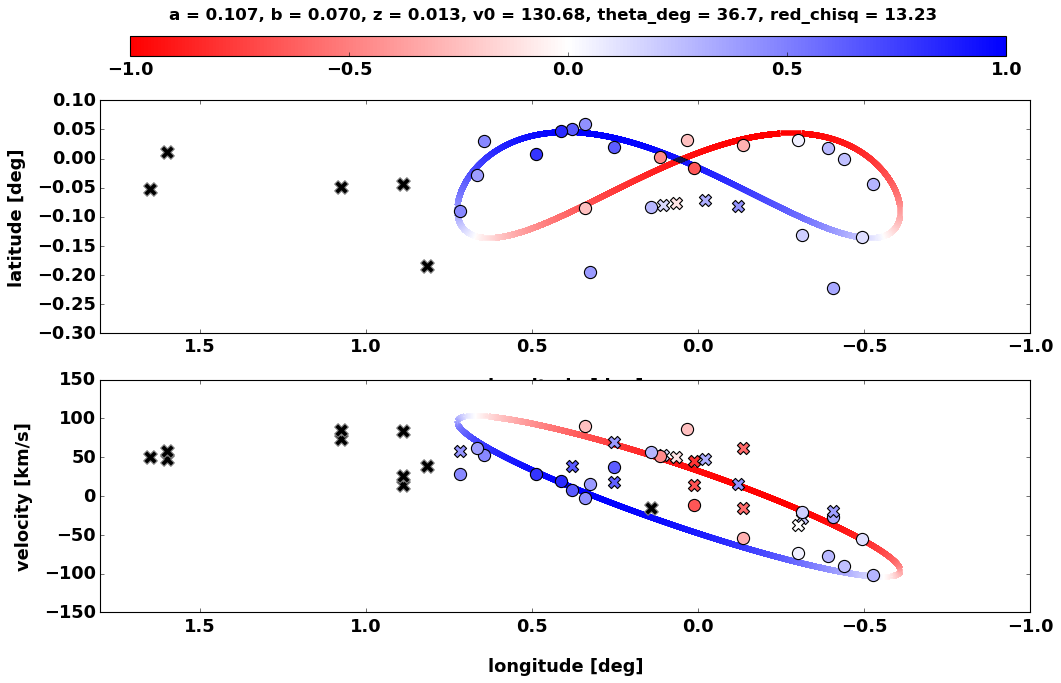

80 80
[-0.0234633] [-0.00248793]
[0.31319348] [-0.20215251] [1.] [-1.]


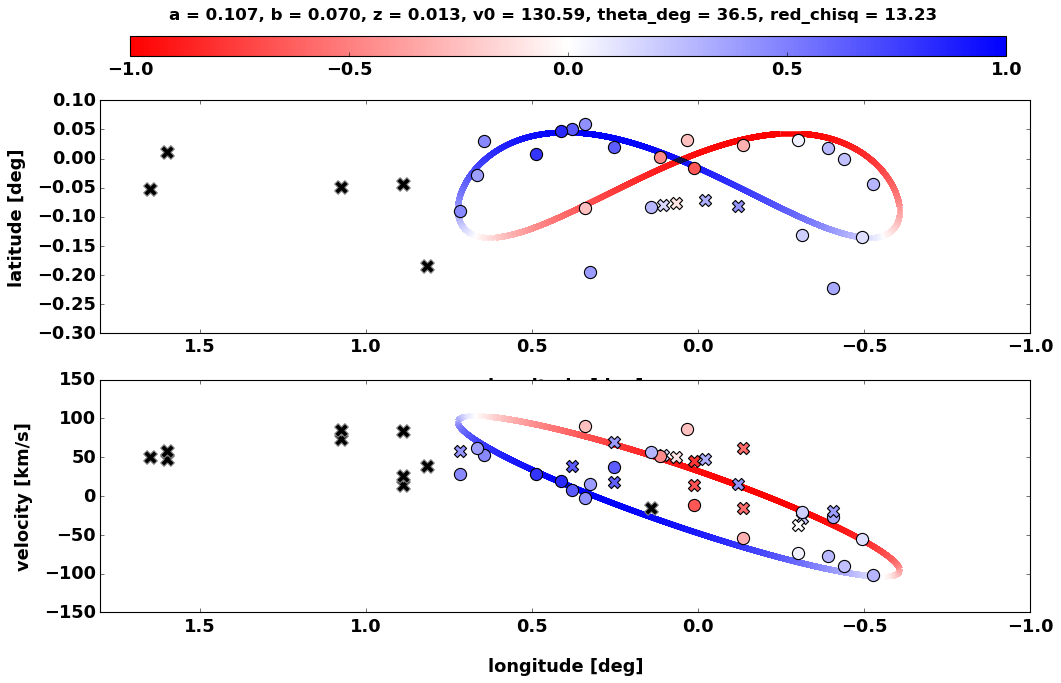

85 85
[-0.02698858] [-0.00723149]
[0.29437532] [-0.18357942] [1.] [-1.]


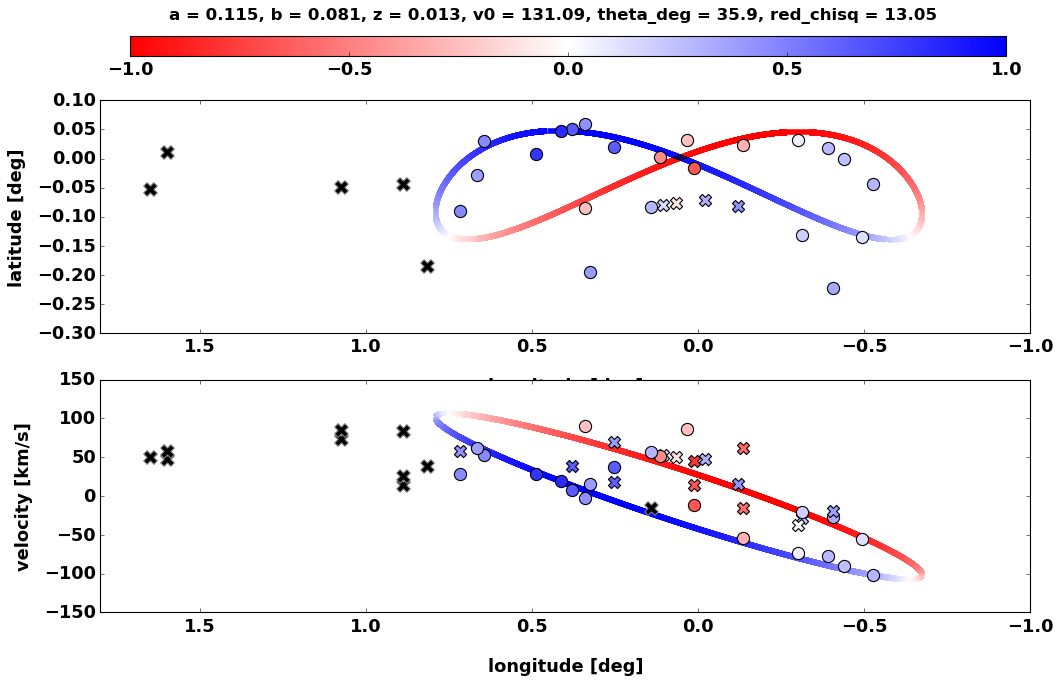

90 90
[-0.01797205] [-0.00268323]
[0.24954328] [-0.13816411] [1.] [-1.]


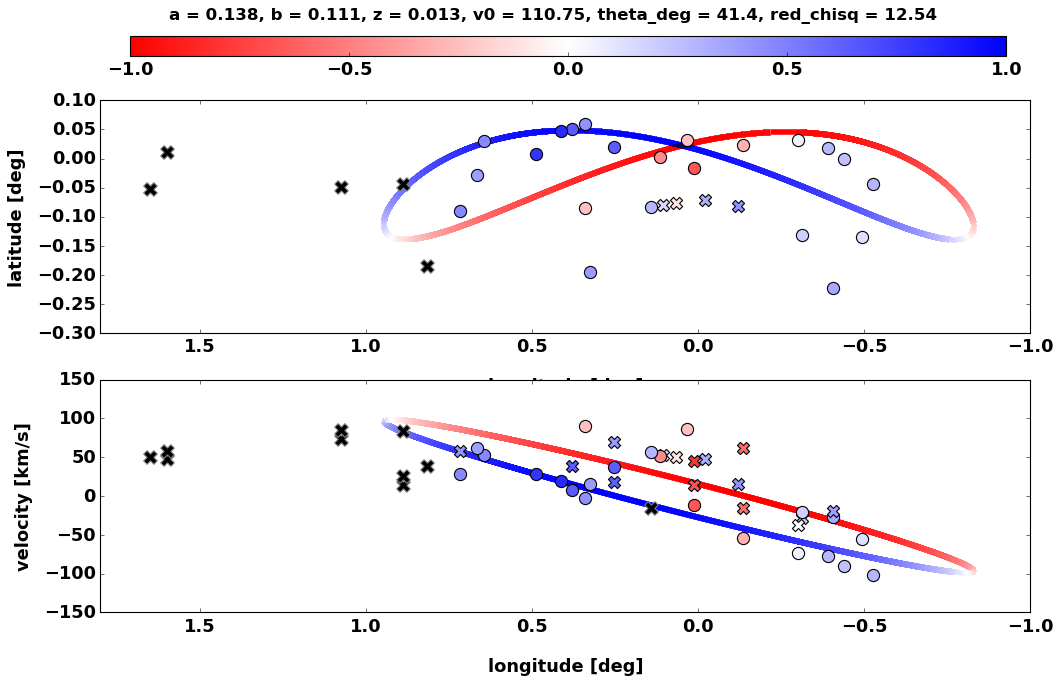

95 95
[-0.01786335] [-0.00181749]
[0.24935399] [-0.13796394] [1.] [-1.]


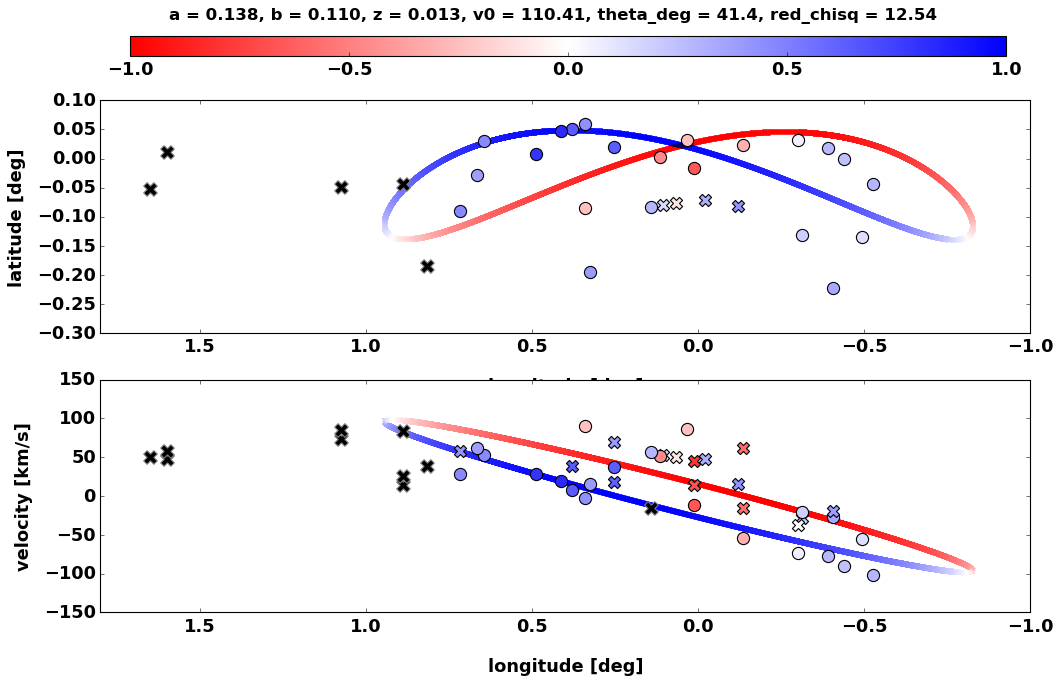

100 100
[-0.01711084] [-0.0016157]
[0.2491342] [-0.13773574] [1.] [-1.]


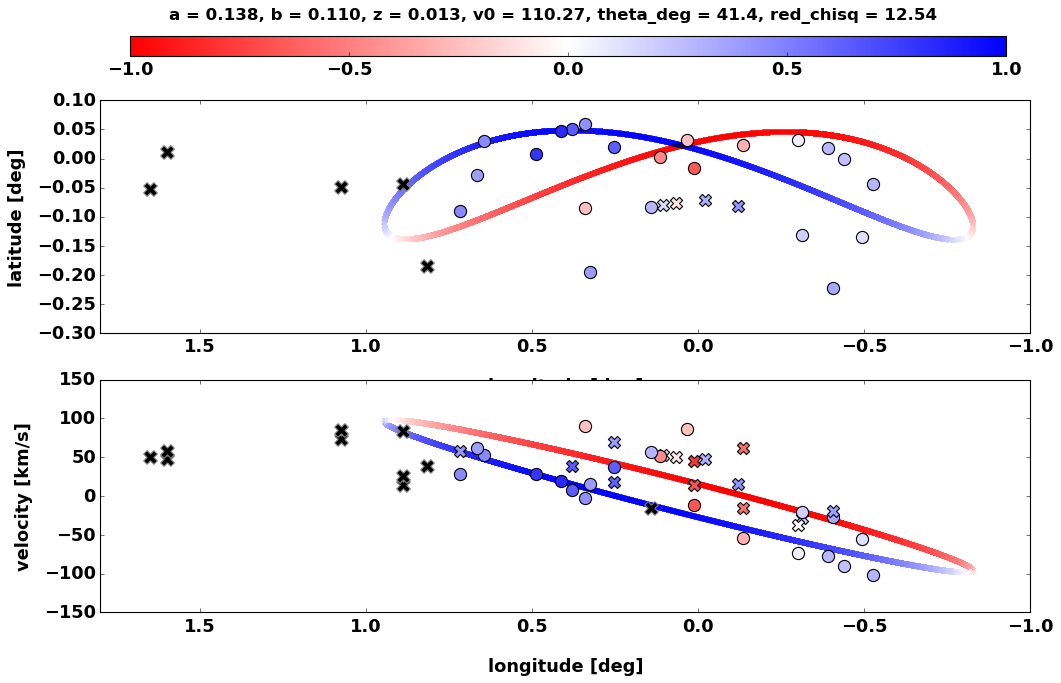

105 105
[-0.01942542] [-0.0036015]
[0.26005954] [-0.14878645] [1.] [-1.]


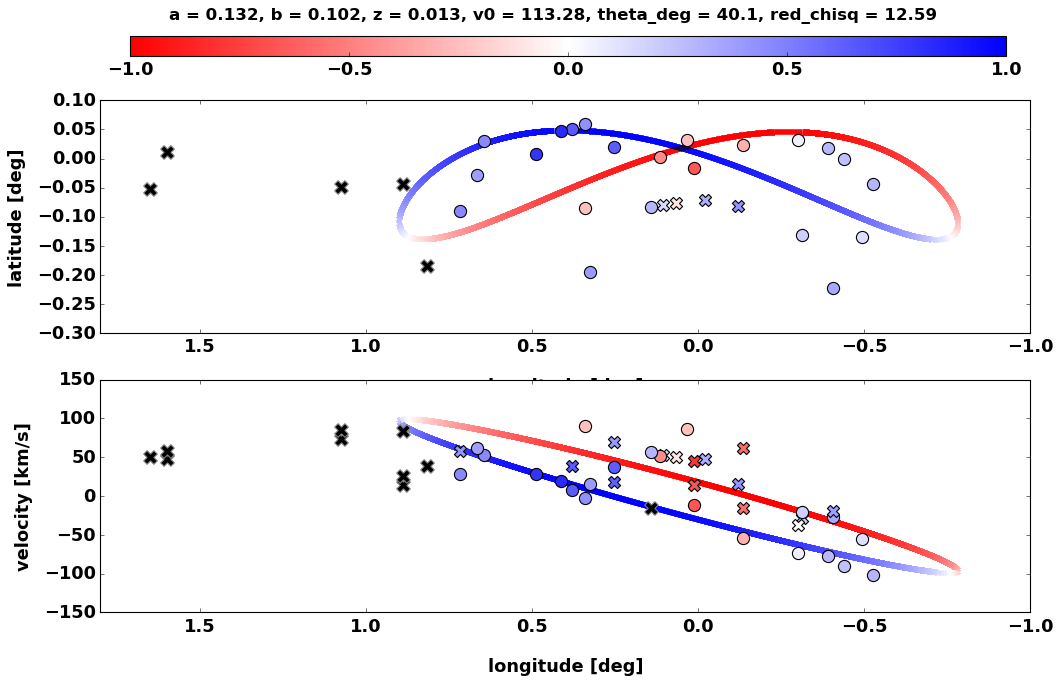

110 110
[-0.01640929] [-0.00126692]
[0.24459654] [-0.13310392] [1.] [-1.]


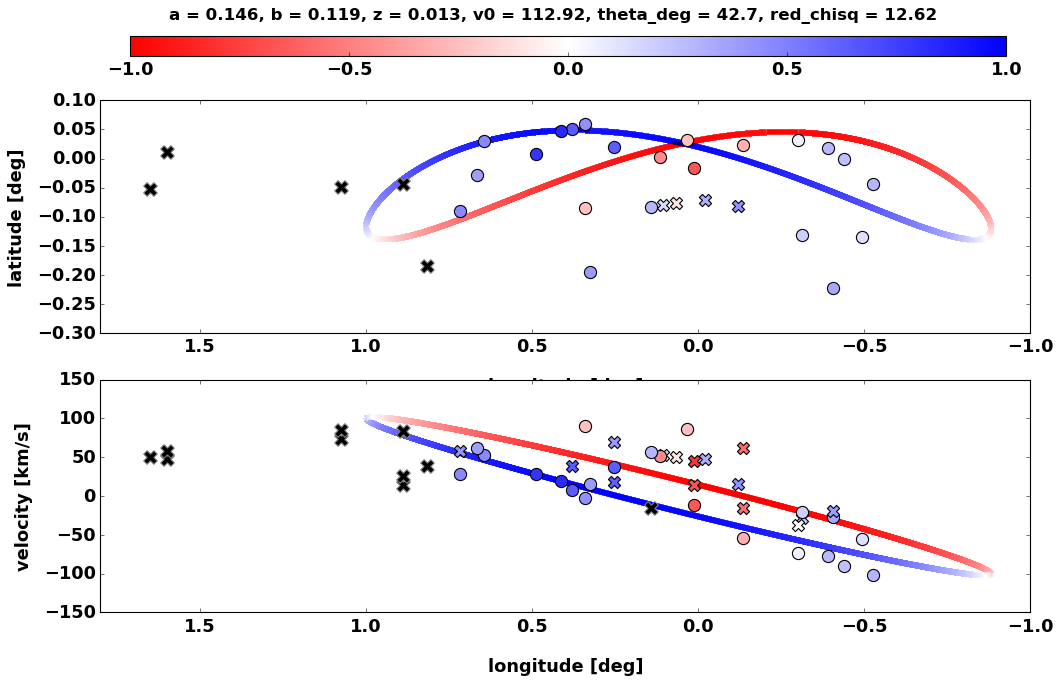

115 115
[-0.01868407] [-0.00015227]
[0.27964703] [-0.16808905] [1.] [-1.]


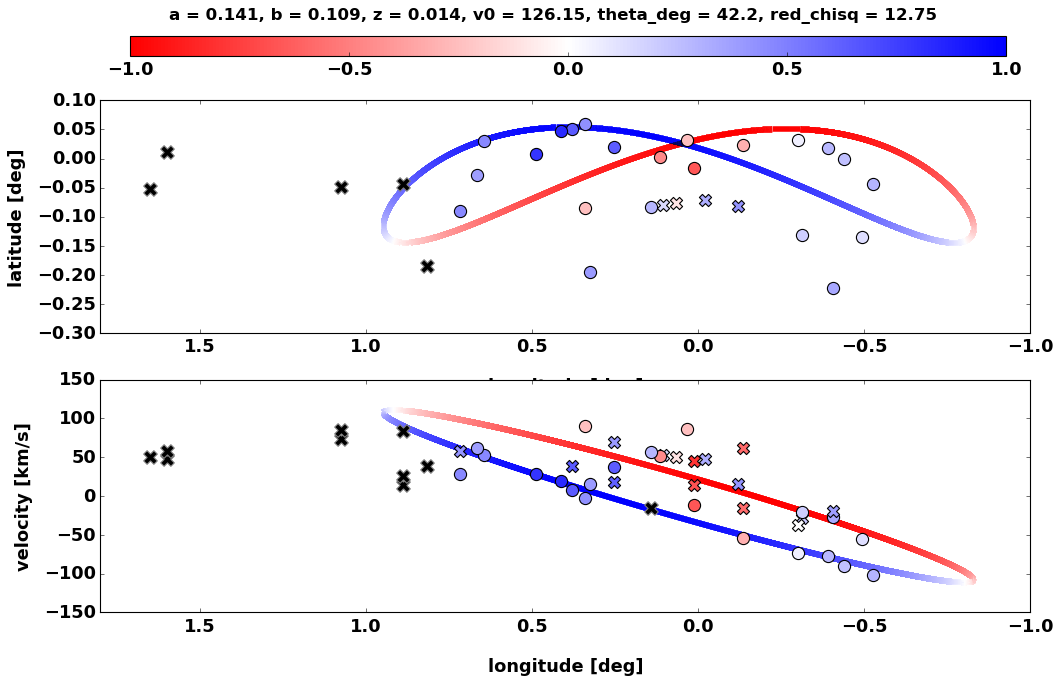

120 120
[-0.00129442] [-0.02049355]
[-0.17797083] [0.2909941] [1.] [-1.]
125 125
[-0.00161828] [-0.0194818]
[-0.17839869] [0.2914234] [1.] [-1.]
130 130
[0.01918017] [-0.00855407]
[-0.21963612] [0.33854979] [1.] [-1.]
135 135
[0.010032] [-0.01080413]
[-0.18983185] [0.30453899] [1.] [-1.]
140 140
[-0.01683626] [-0.00127329]
[0.24922155] [-0.1378227] [1.] [-1.]


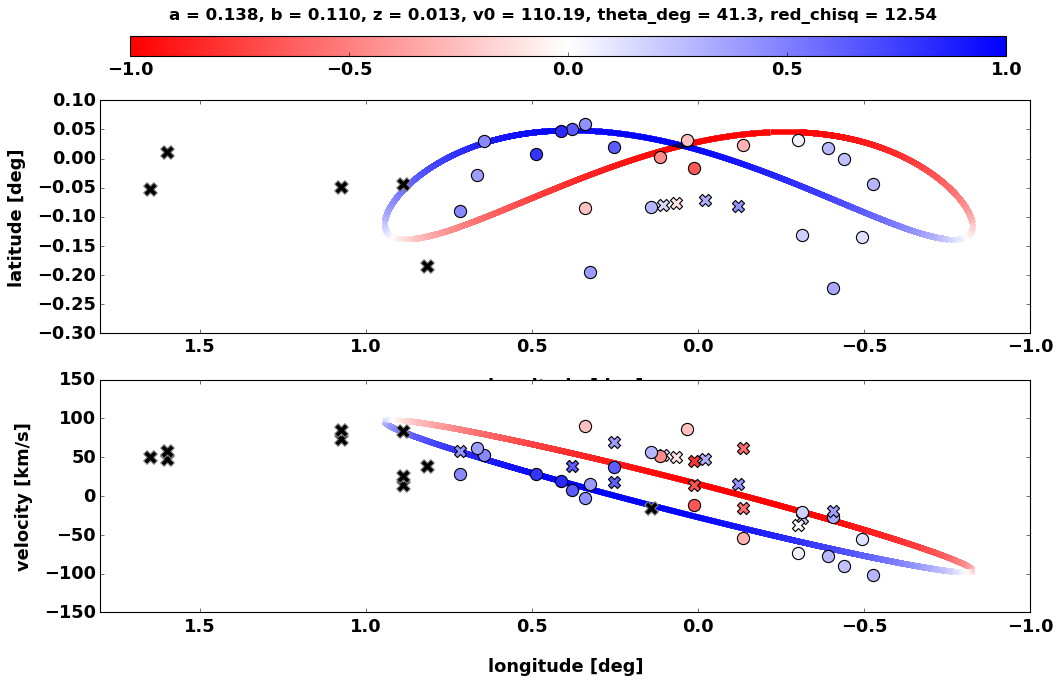

145 145
[-0.01988208] [-0.00238777]
[0.27086285] [-0.15959513] [1.] [-1.]


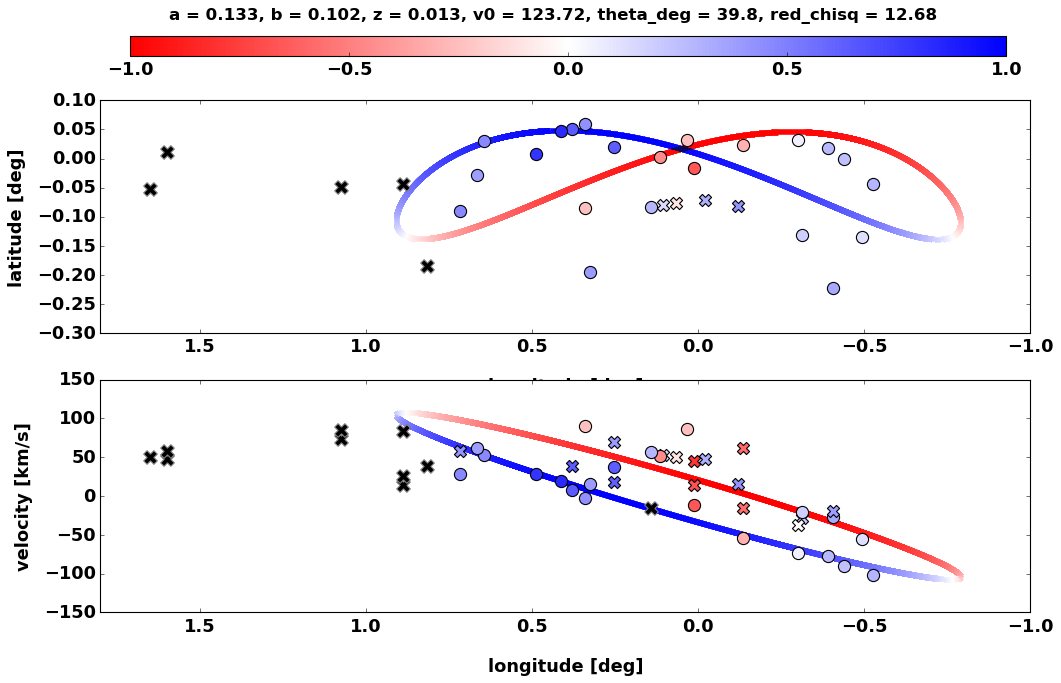

150 150
[-0.01906097] [-0.00230993]
[0.26404908] [-0.15274555] [1.] [-1.]


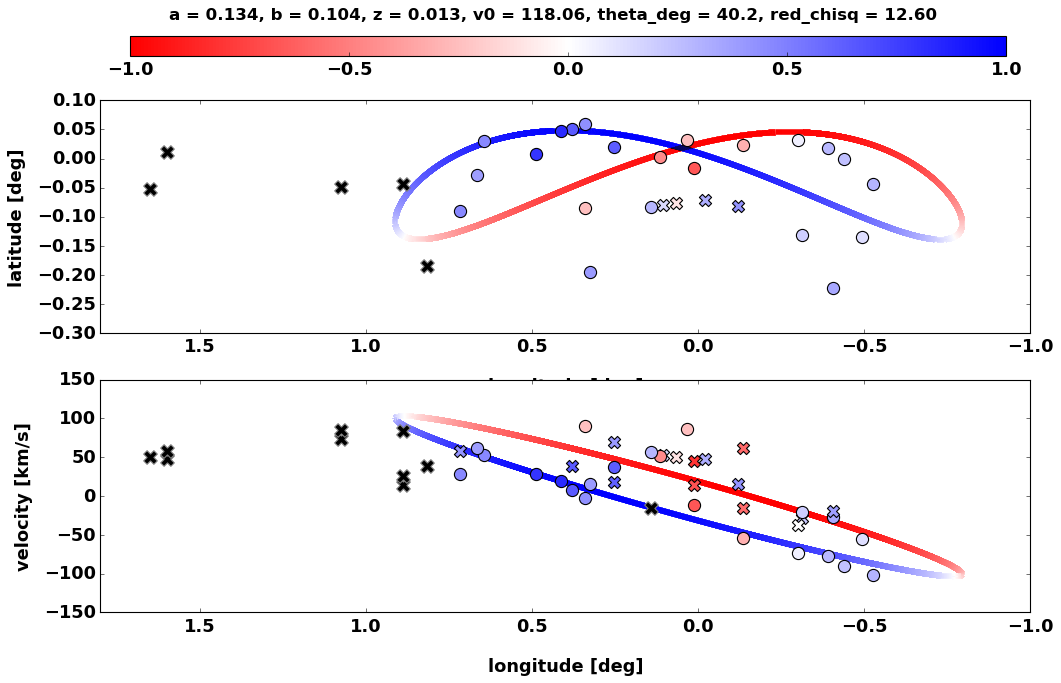

155 155
[-0.01931817] [0.00039729]
[0.29314088] [-0.18183236] [1.] [-1.]


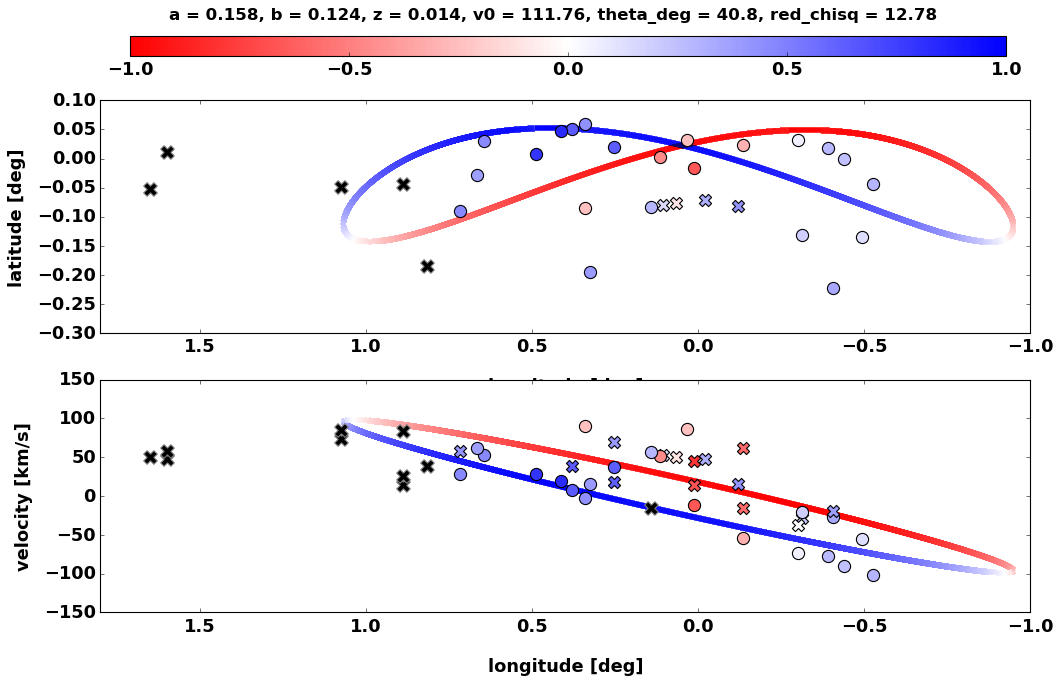

160 160
[-0.01807939] [-0.00121633]
[0.24945344] [-0.13806037] [1.] [-1.]


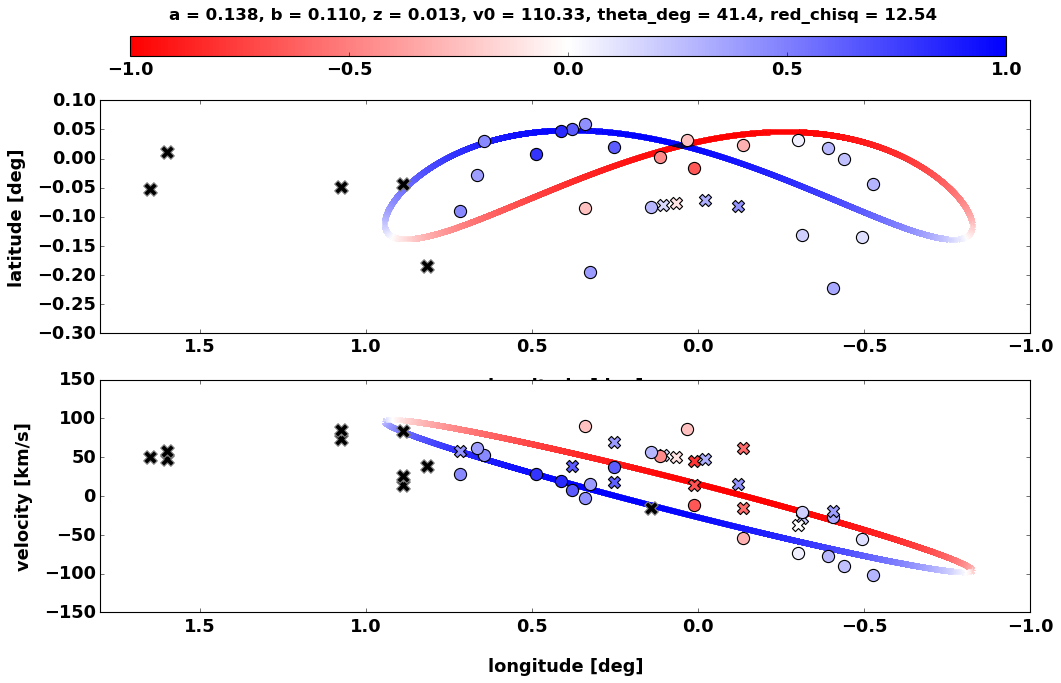

165 165
[-0.02209822] [-0.00270835]
[0.28385373] [-0.17255446] [1.] [-1.]


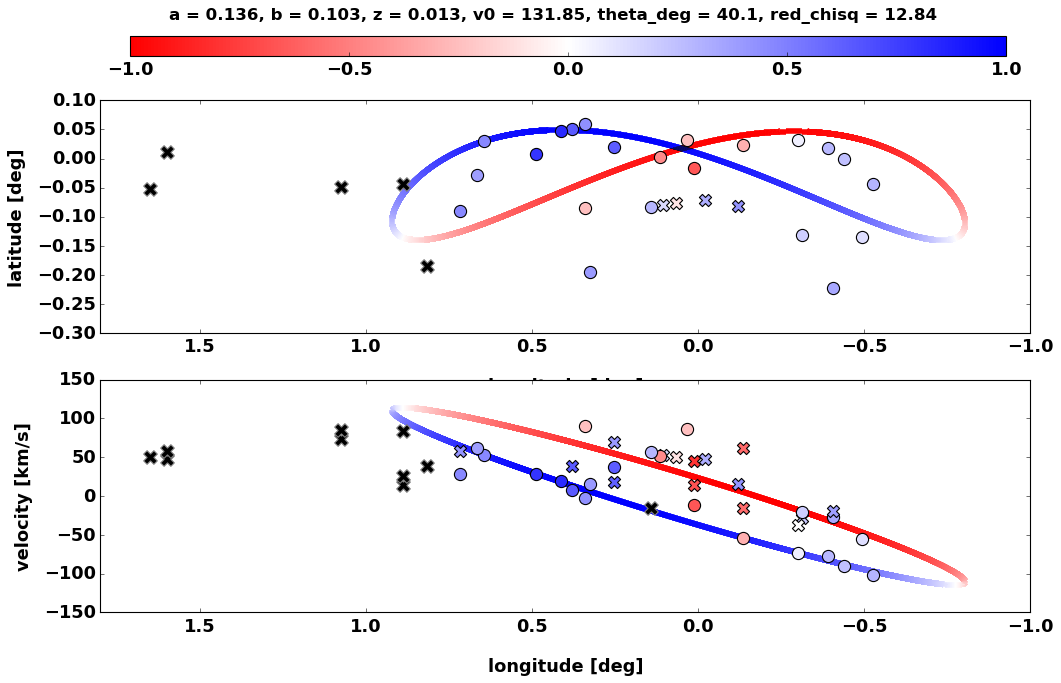

170 170
[-0.02184222] [-0.0012704]
[0.30054752] [-0.18911087] [1.] [-1.]


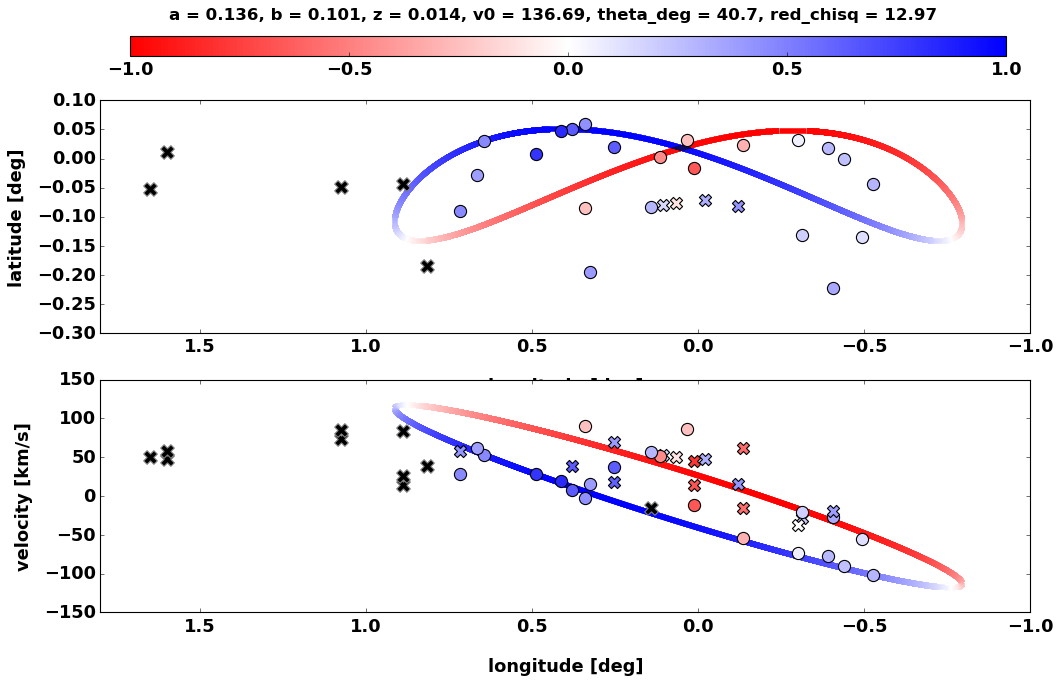

175 175
[-0.01987533] [-7.54445919e-05]
[0.29680838] [-0.18520899] [1.] [-1.]


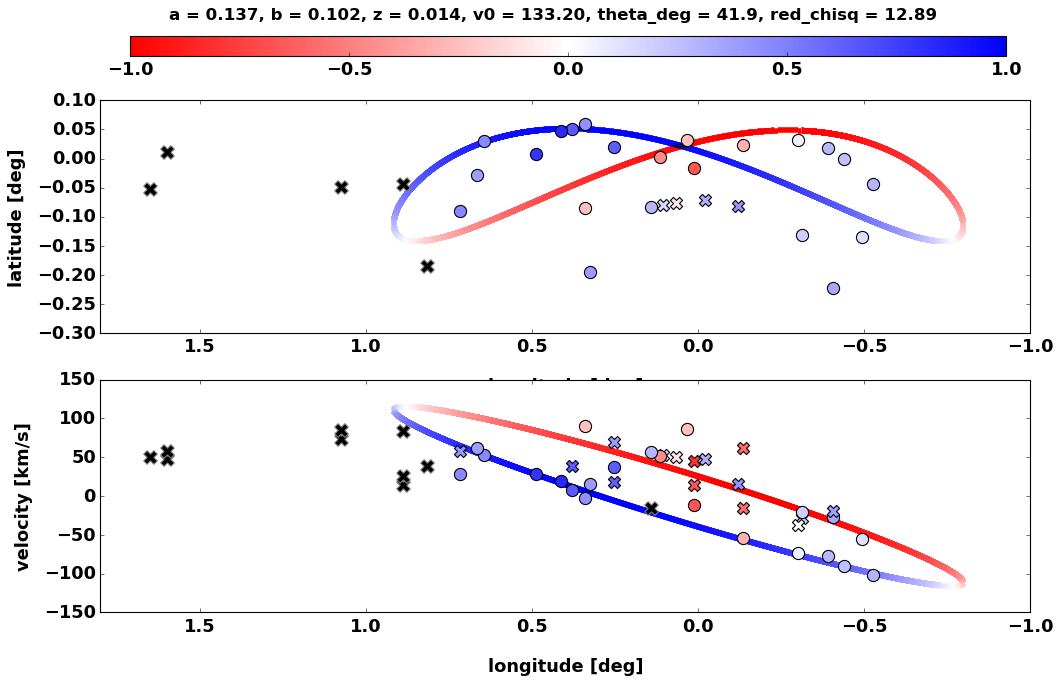

180 180
[-0.02061037] [-0.00104876]
[0.30056858] [-0.18914049] [1.] [-1.]


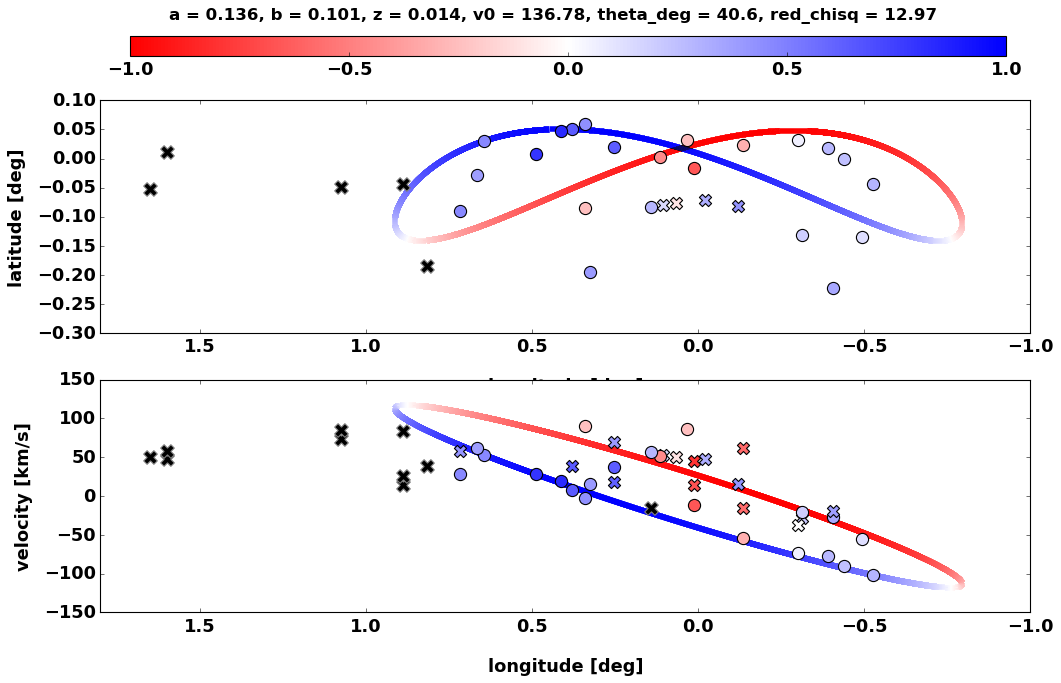

185 185
[-0.02932365] [-0.00682723]
[0.32819424] [-0.21742156] [1.] [-1.]


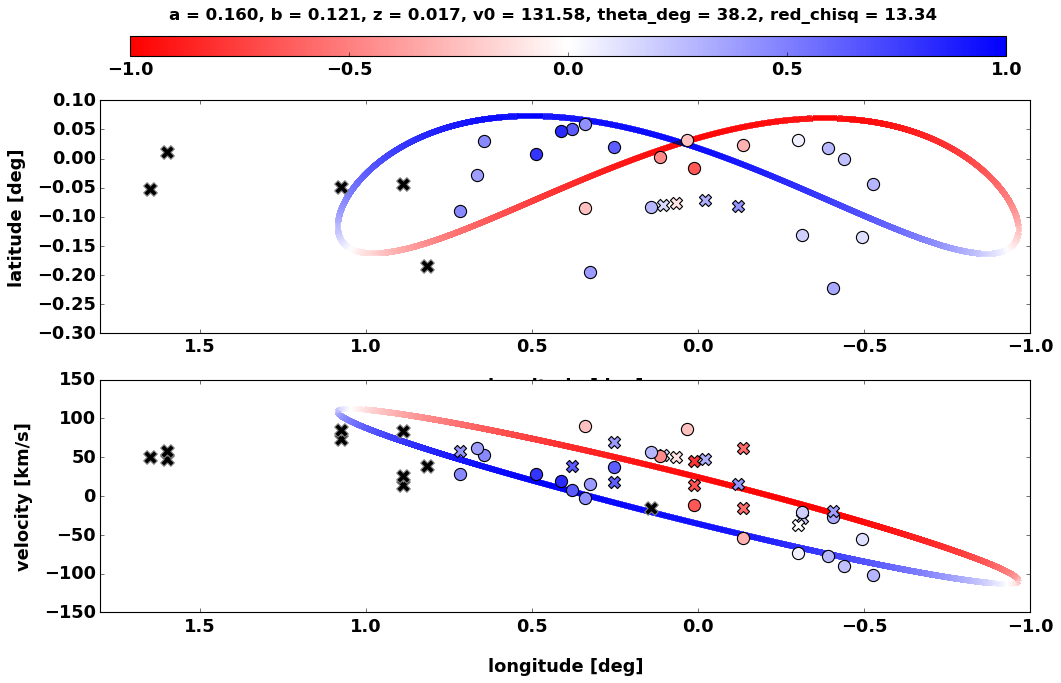

190 190
[-0.02411674] [-0.00186905]
[0.32103028] [-0.20978932] [1.] [-1.]


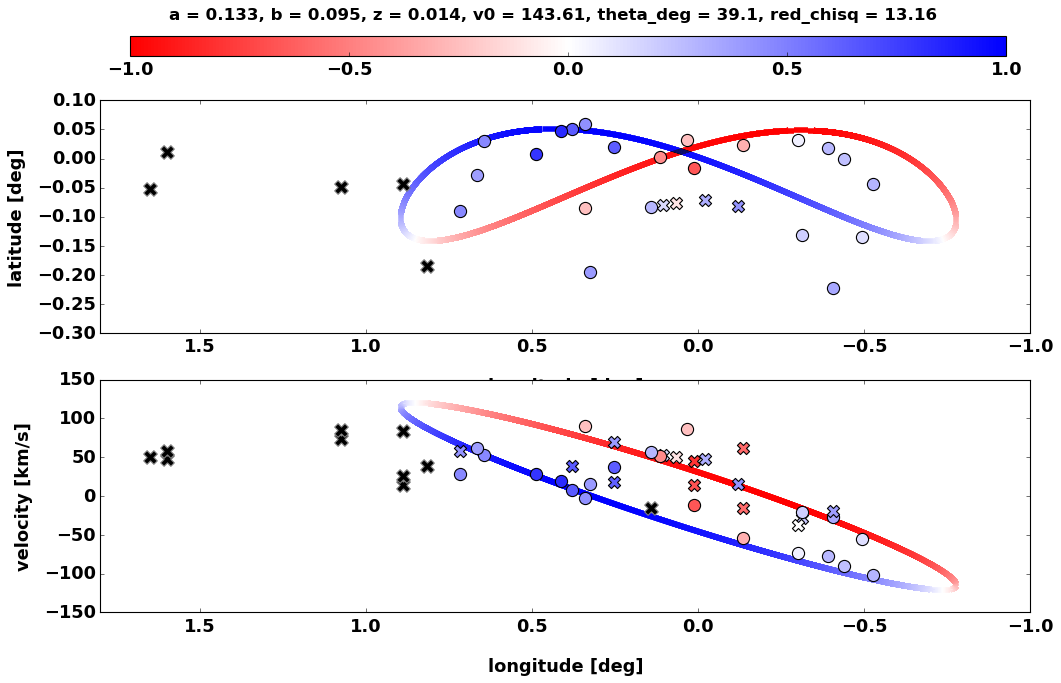

195 195
[-0.03354579] [-0.00958792]
[0.33540779] [-0.22491751] [1.] [-1.]


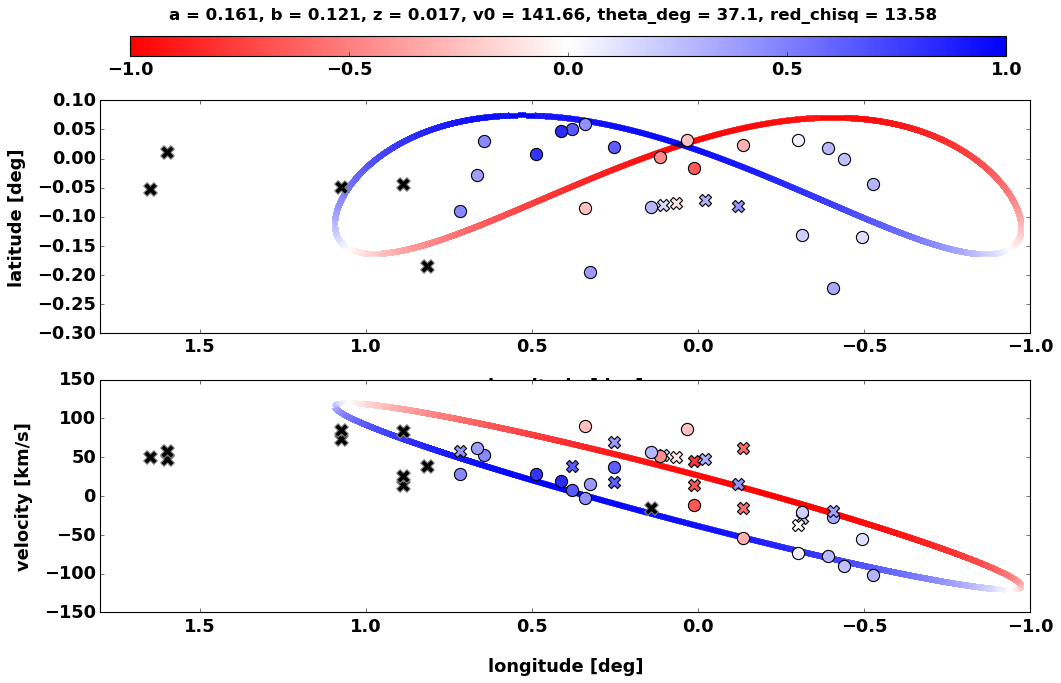

200 200
[-0.00992229] [0.01011304]
[0.3100324] [-0.19717643] [1.] [-1.]


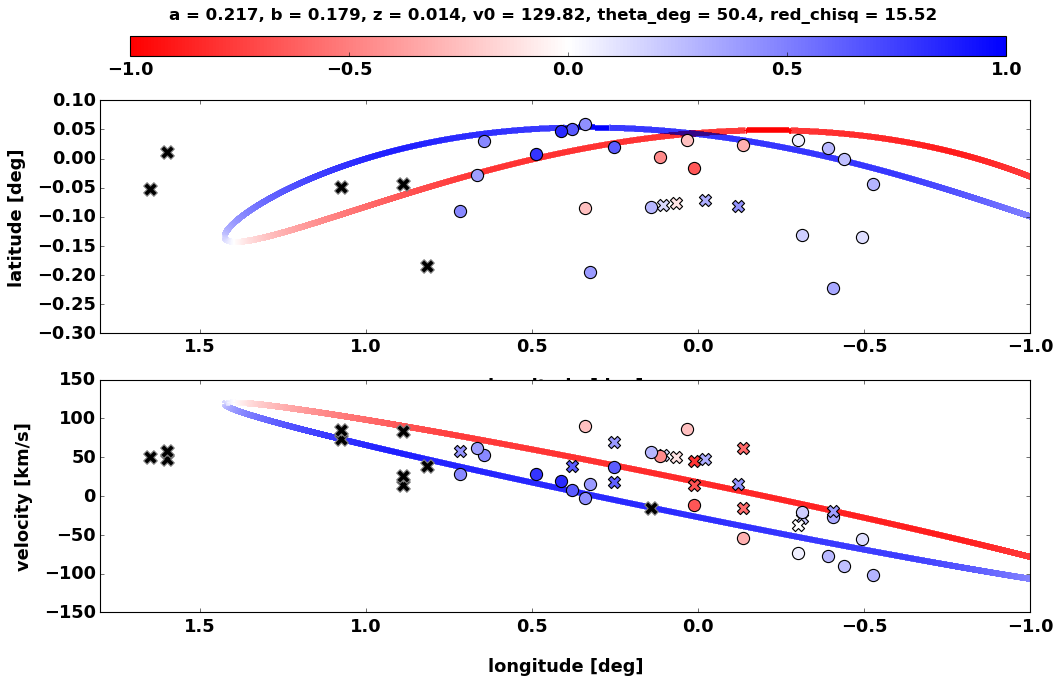

205 205
[-0.01671061] [-0.00129305]
[0.24950825] [-0.13809434] [1.] [-1.]


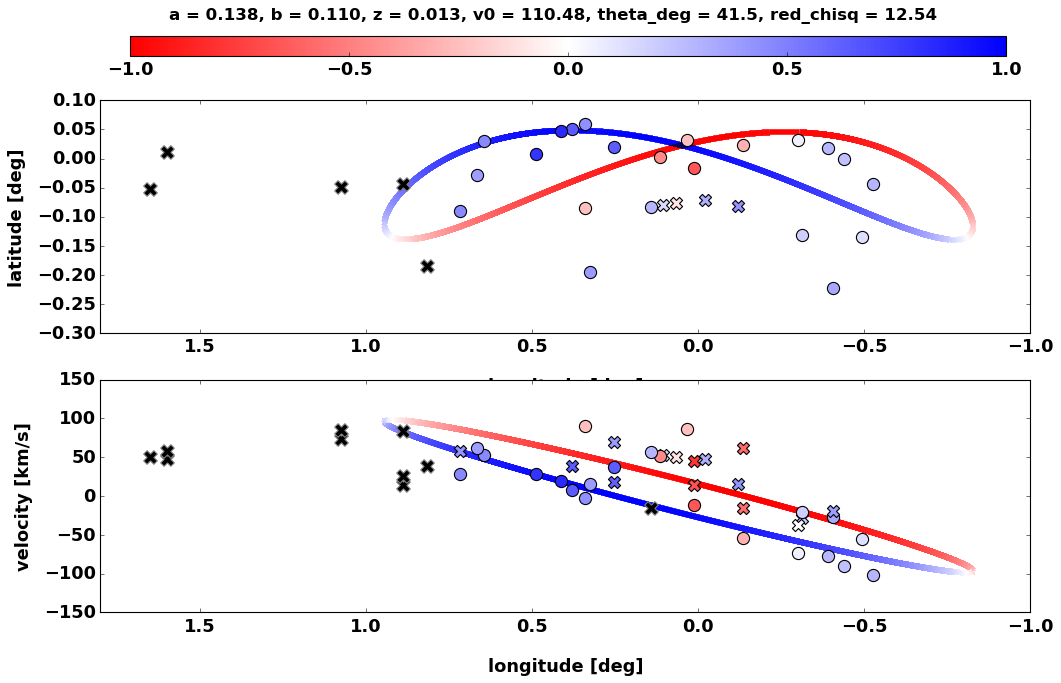

210 210
[-0.0202283] [-0.00331159]
[0.27221707] [-0.16087707] [1.] [-1.]


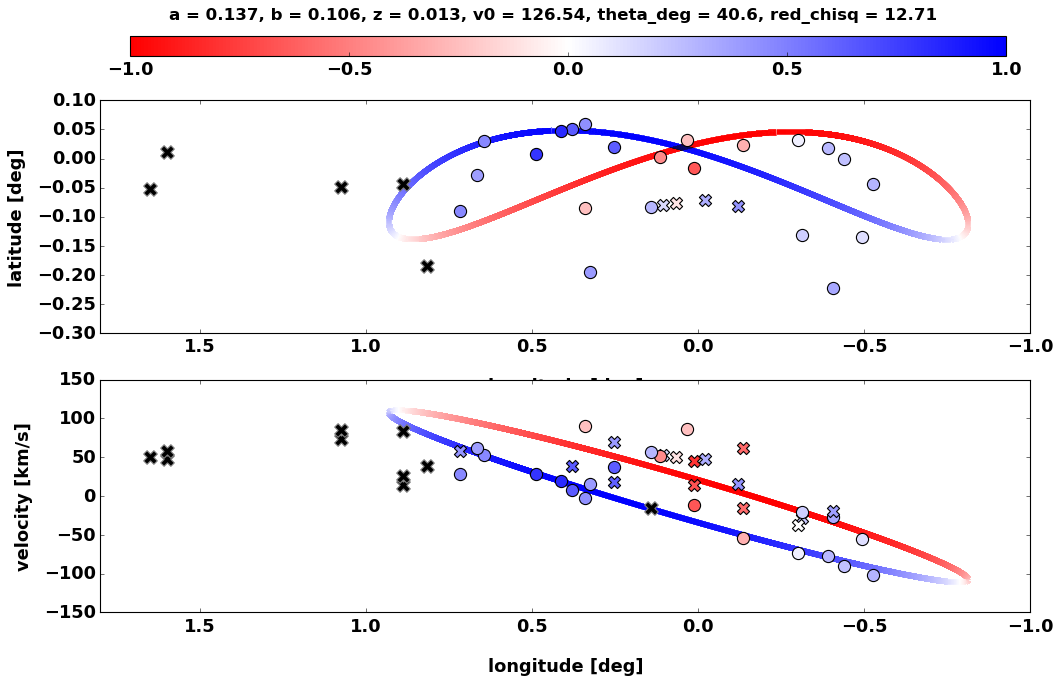

215 215
[-0.01978621] [-0.00296767]
[0.27430051] [-0.16296235] [1.] [-1.]


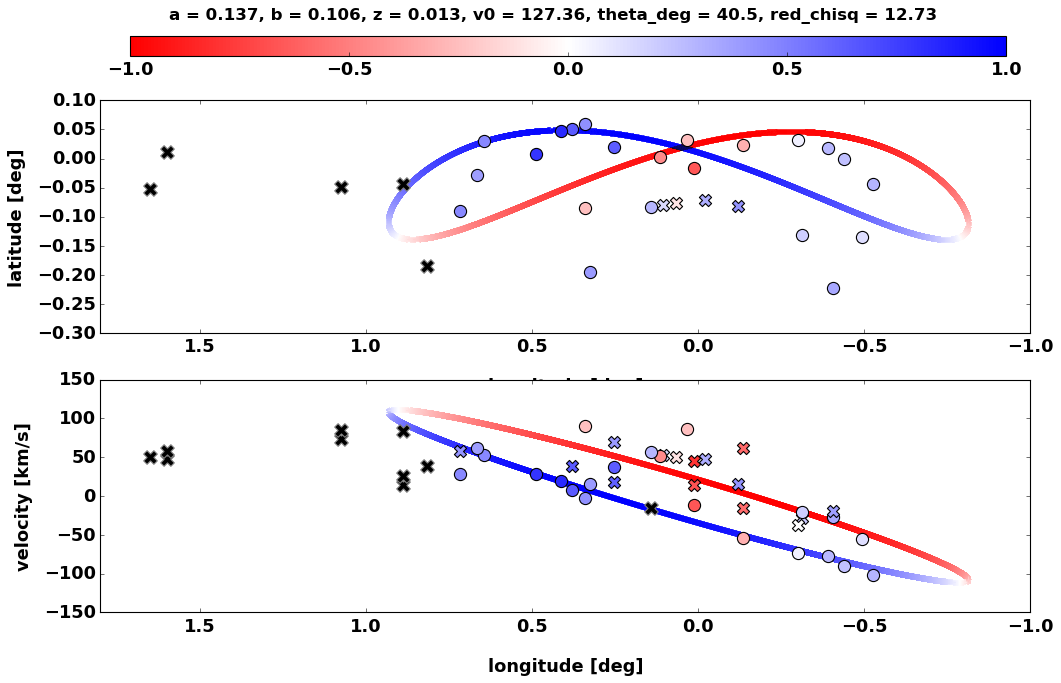

220 220
[-0.00246187] [0.01570542]
[0.29046495] [-0.17673911] [1.] [-1.]


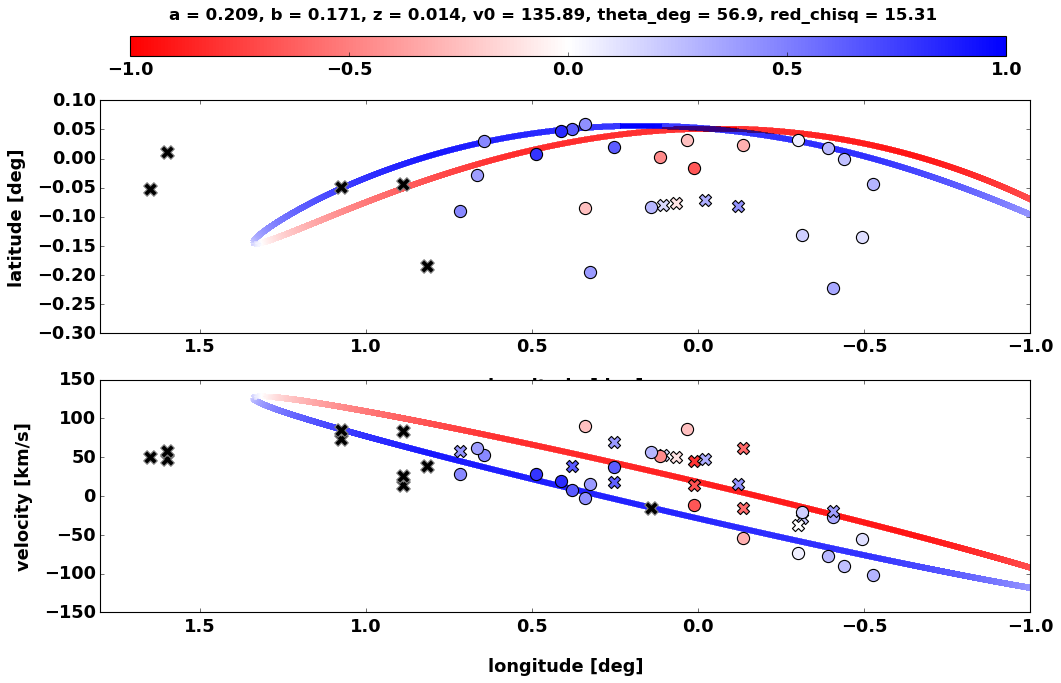

225 225
[-0.0096441] [0.01018394]
[0.31272682] [-0.19949859] [1.] [-1.]


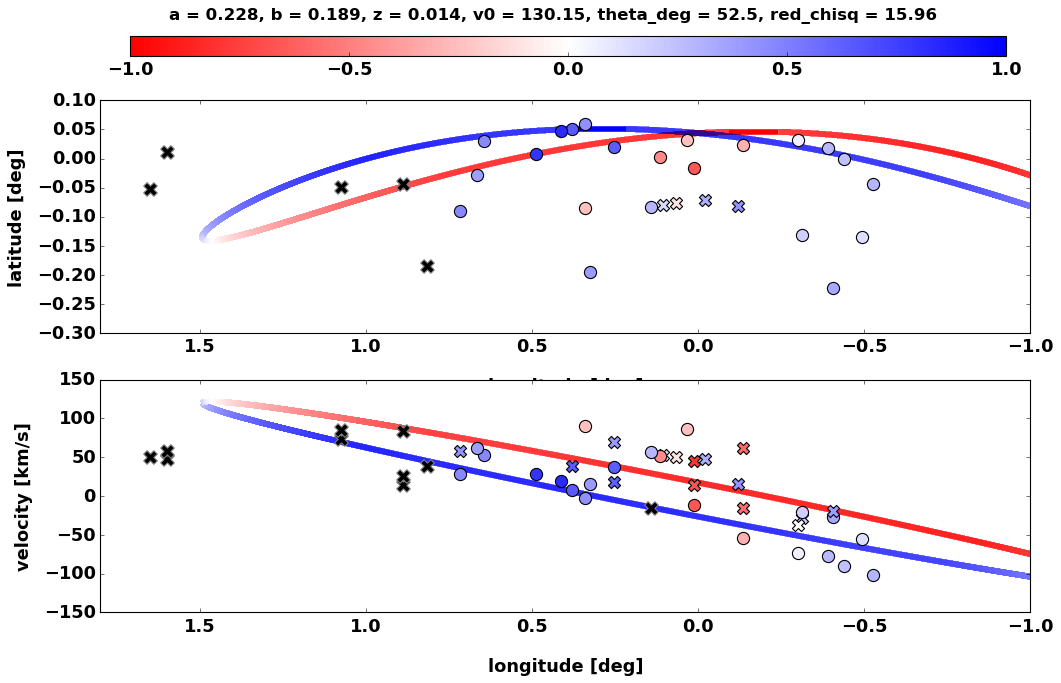

230 230
[-0.00812301] [0.00504342]
[0.22839465] [-0.11620713] [1.] [-1.]


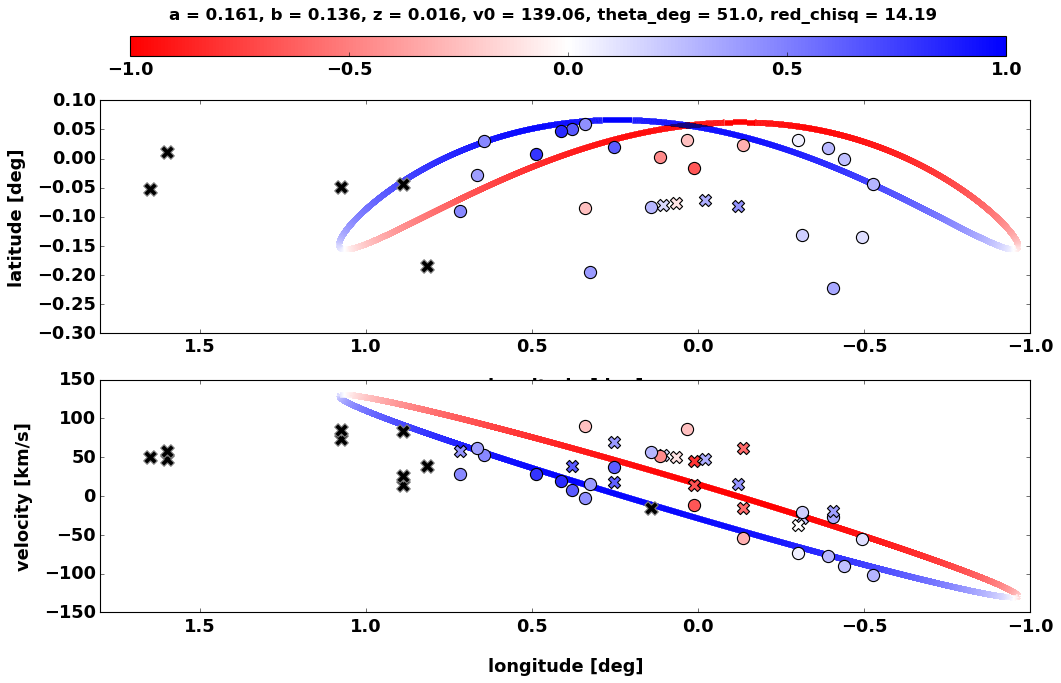

235 235
[-0.01922633] [0.00182129]
[0.30408252] [-0.19249625] [1.] [-1.]


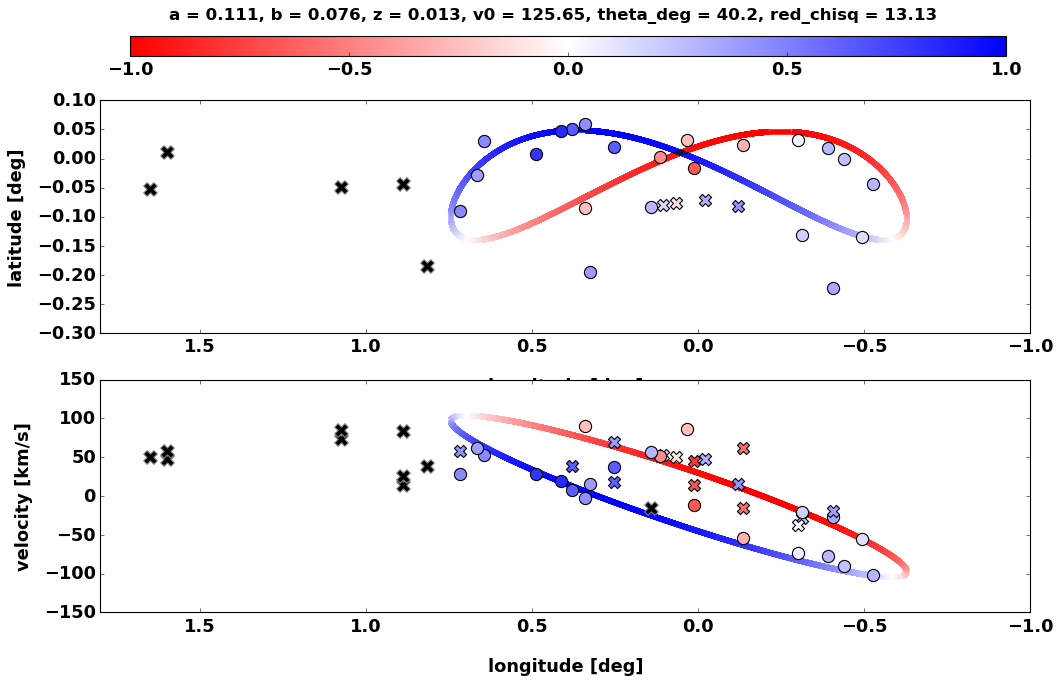

240 240
[-0.02127414] [-0.00253817]
[0.27653895] [-0.16520882] [1.] [-1.]


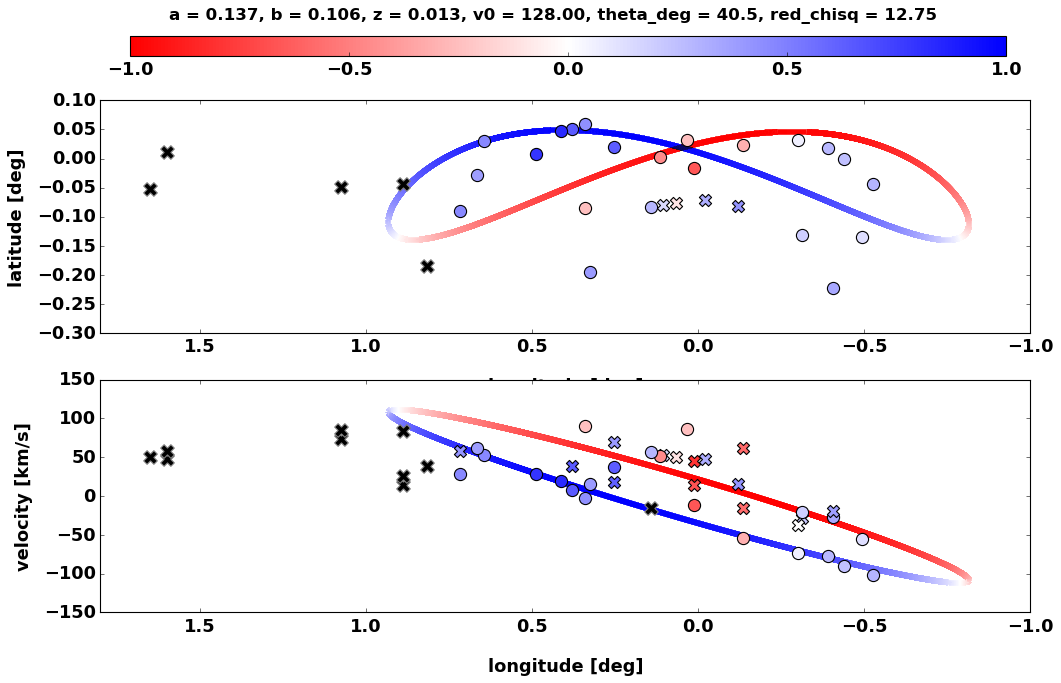

245 245
[-0.02033803] [-0.00281786]
[0.27234324] [-0.16102705] [1.] [-1.]


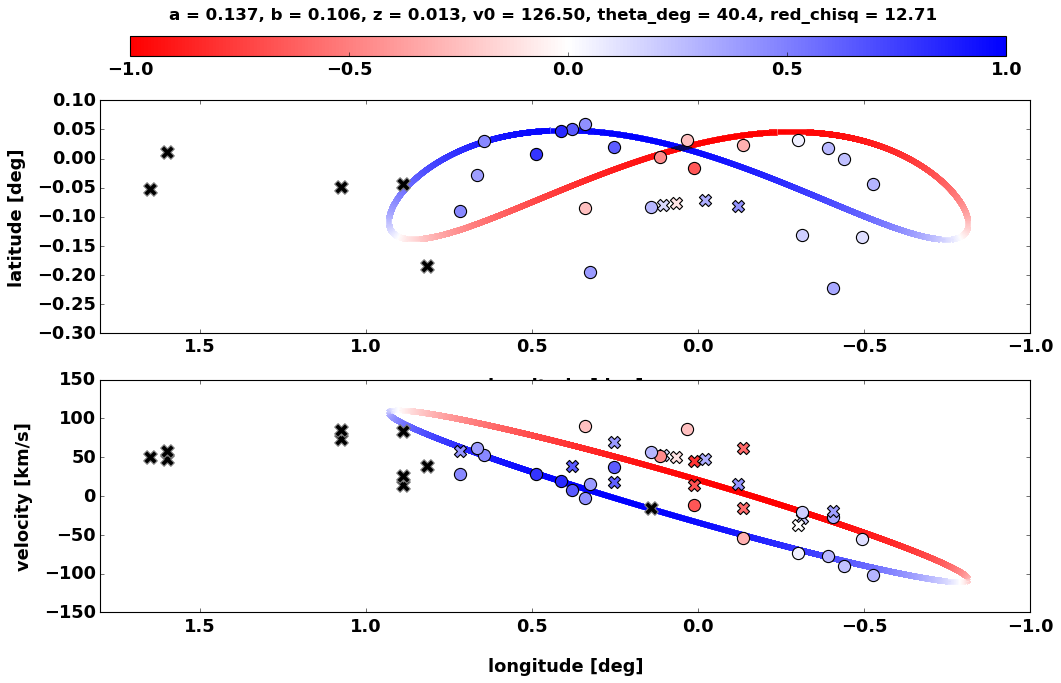

250 250
[-0.02078267] [-0.00289894]
[0.27594622] [-0.16462173] [1.] [-1.]


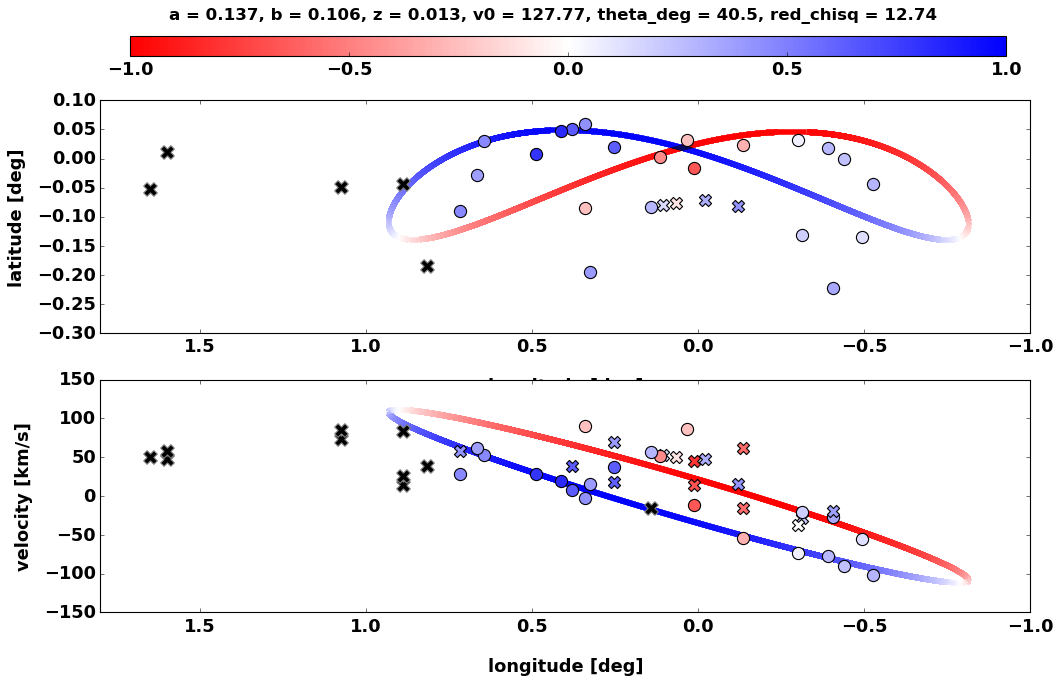

255 255
[-0.02130581] [-0.00278228]
[0.2879016] [-0.17655084] [1.] [-1.]


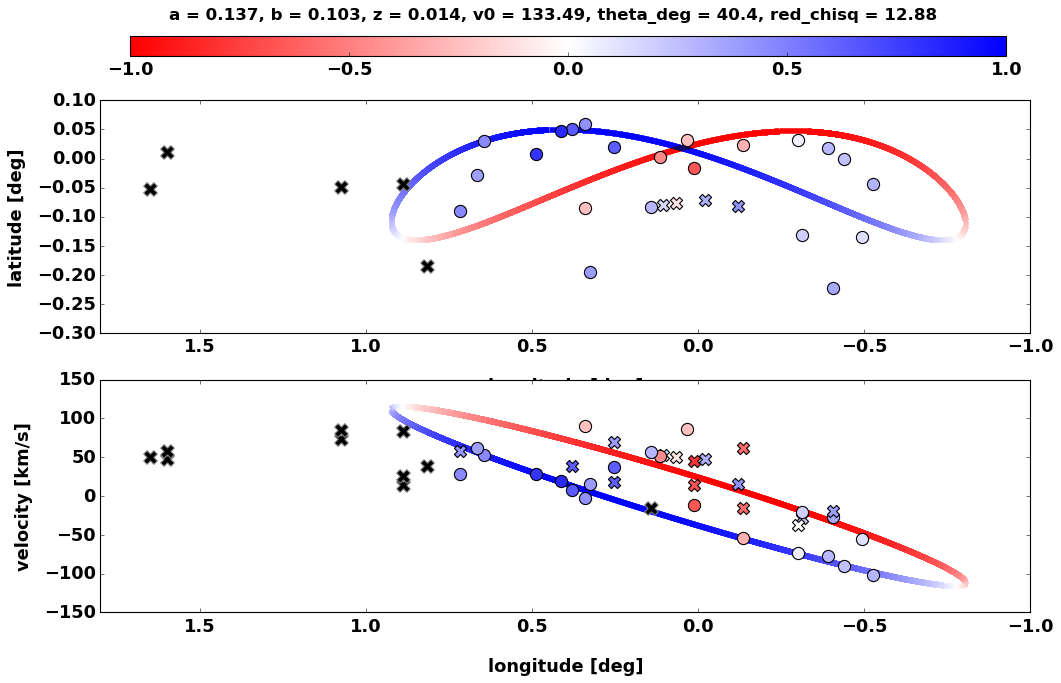

260 260
[-0.02199196] [-0.00334711]
[0.27880053] [-0.16755754] [1.] [-1.]


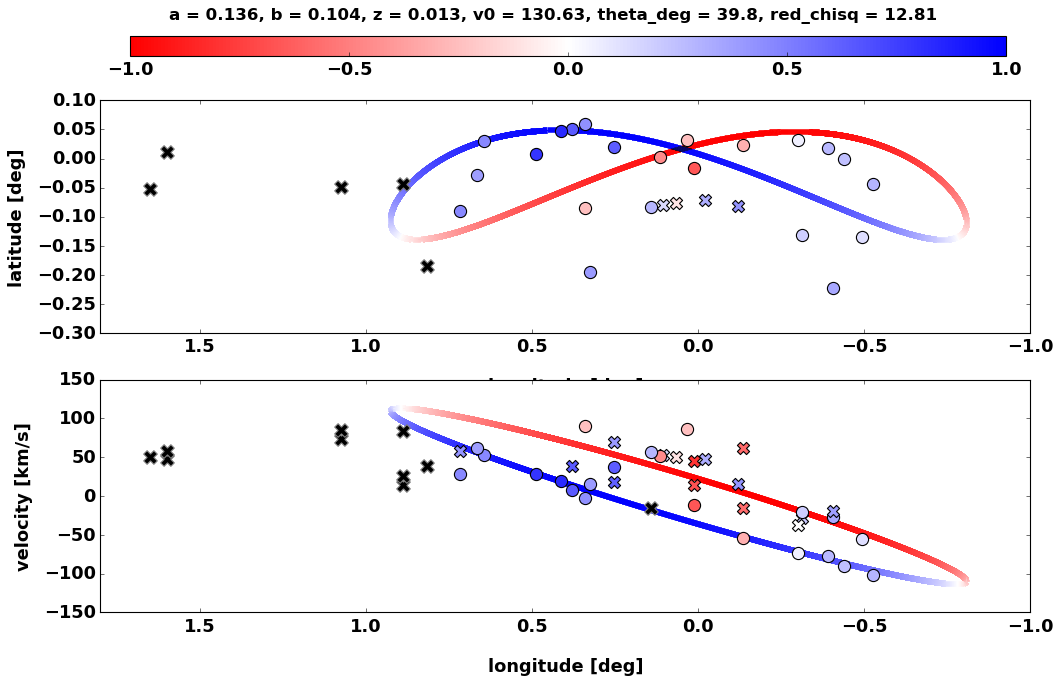

265 265
[-0.02115071] [-0.0025789]
[0.29506263] [-0.18376437] [1.] [-1.]


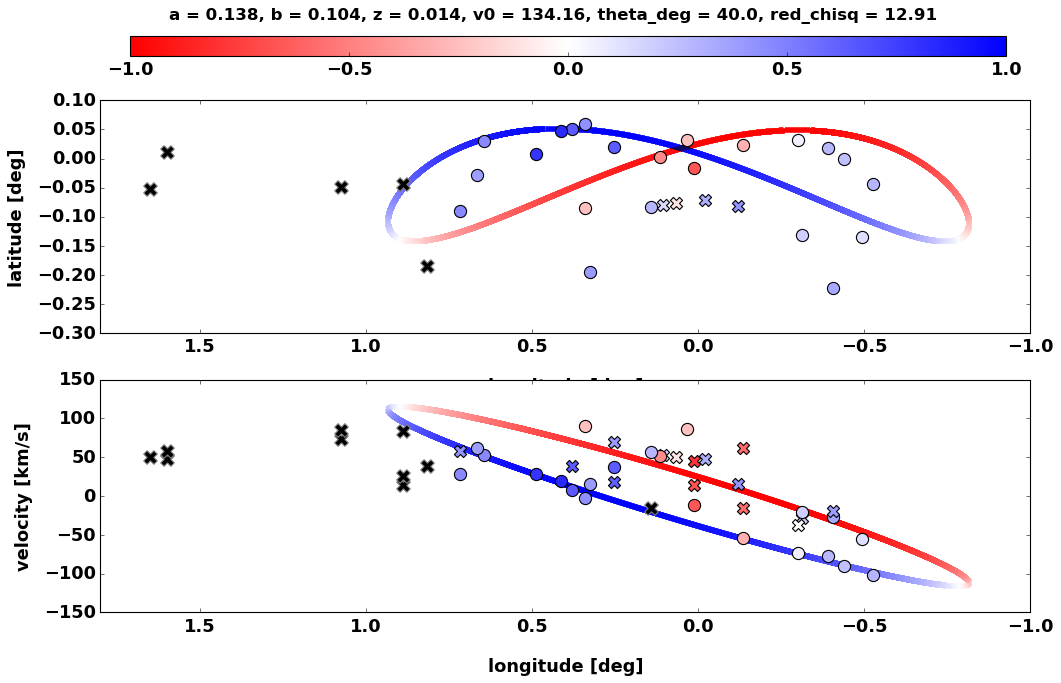

270 270
[-0.02607354] [-0.00740647]
[0.28616325] [-0.17738779] [1.] [-1.]


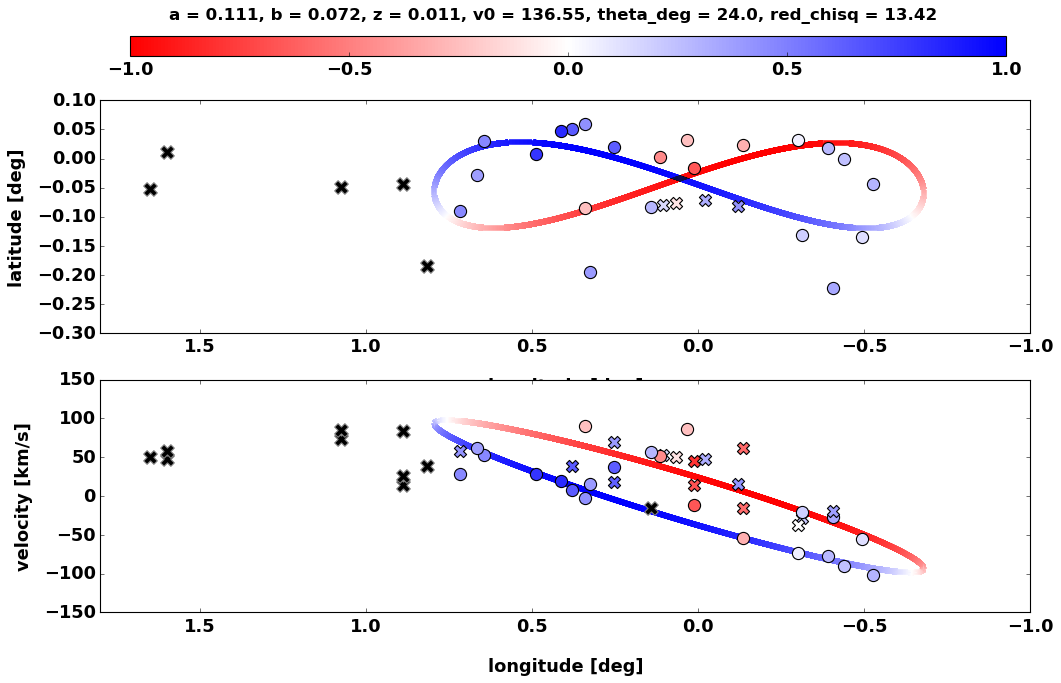

275 275
[-0.02053356] [-0.00301814]
[0.28795786] [-0.17660538] [1.] [-1.]


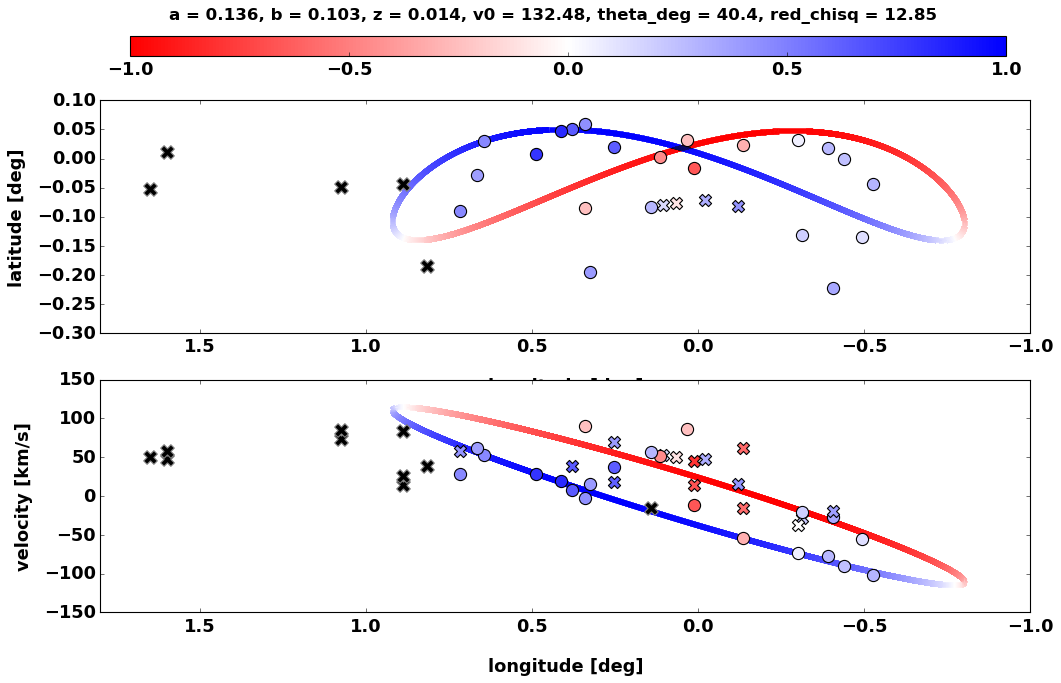

280 280
[-0.02068004] [-0.00283826]
[0.28393195] [-0.17260868] [1.] [-1.]


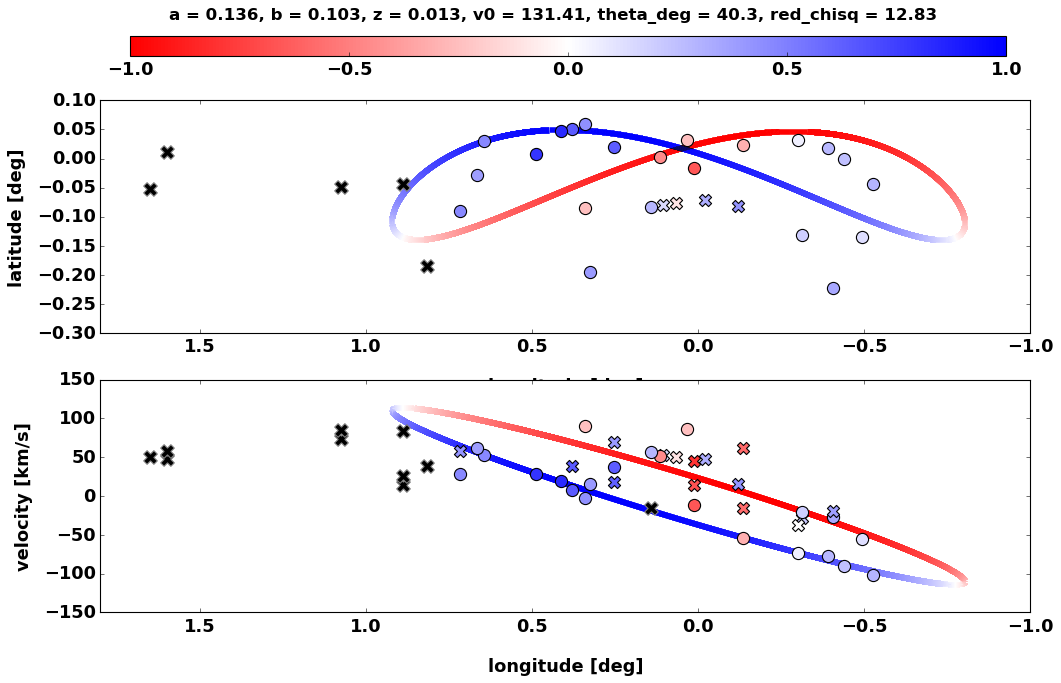

285 285
[-0.02163342] [-0.0025862]
[0.28061941] [-0.16931077] [1.] [-1.]


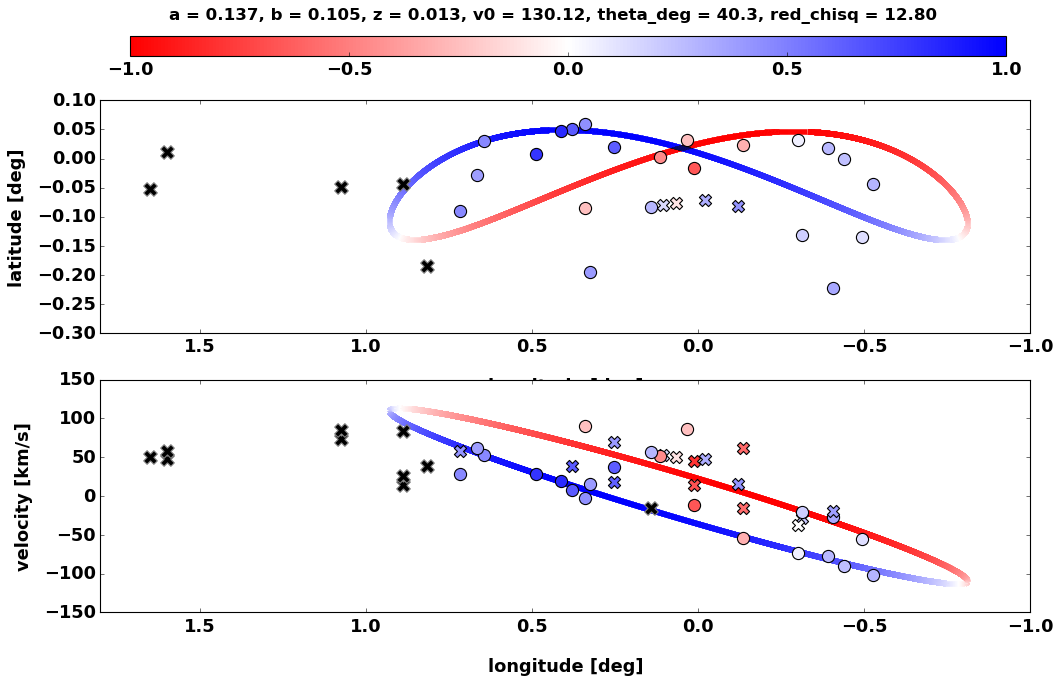

290 290
[-0.02146504] [-0.00206607]
[0.28069763] [-0.16938957] [1.] [-1.]


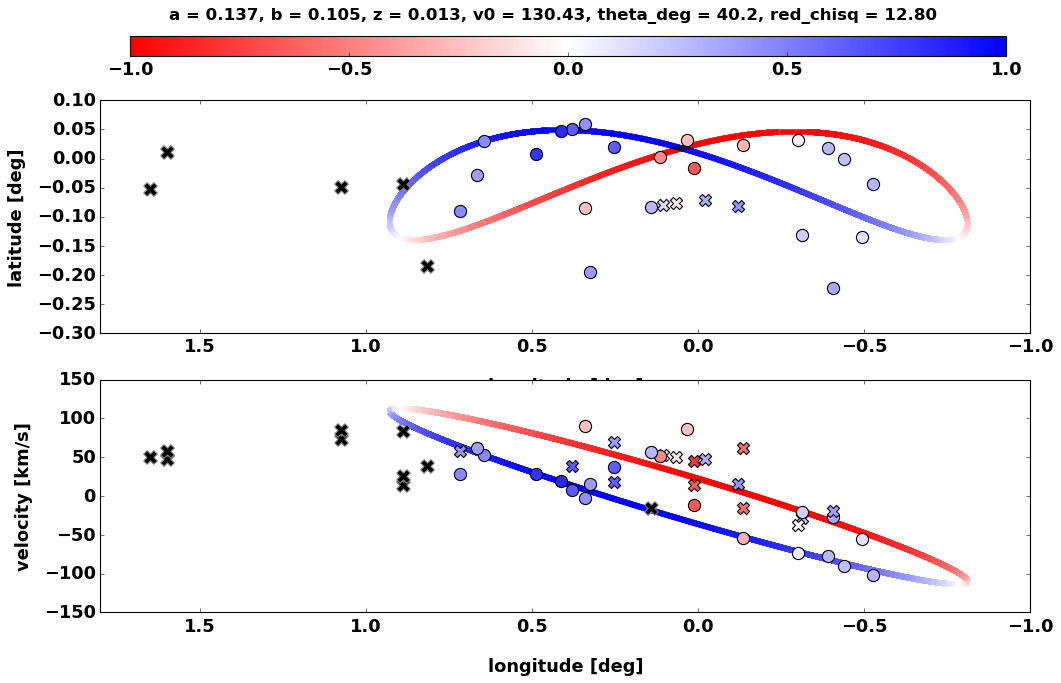

295 295
[-0.02040781] [-0.0032492]
[0.28557564] [-0.17427034] [1.] [-1.]


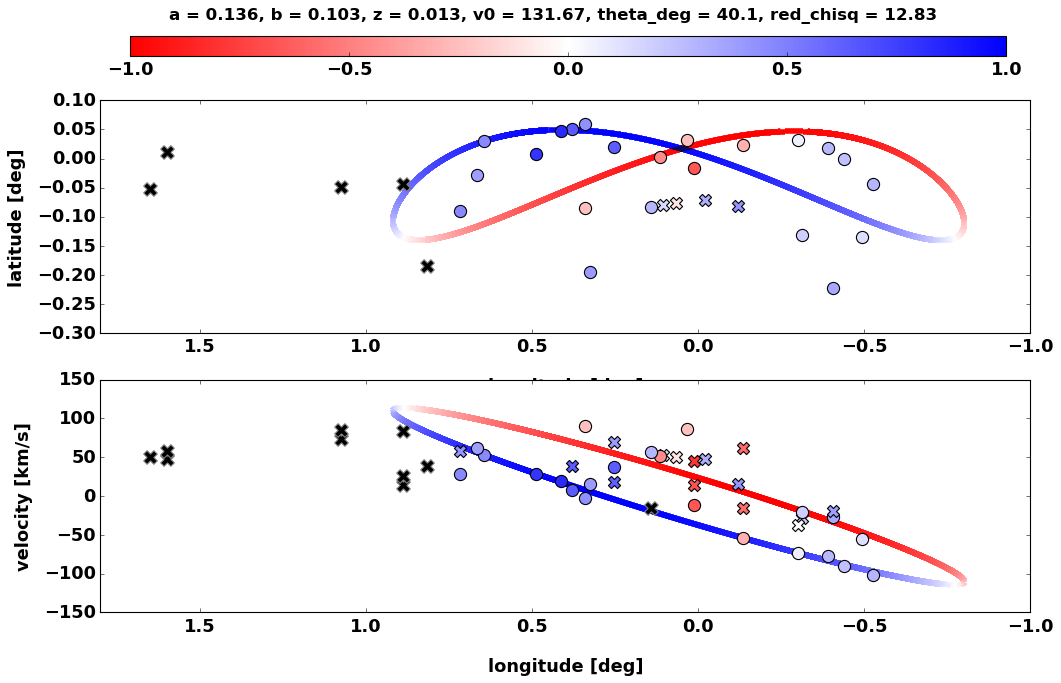

300 300
[-0.02129591] [-0.00257382]
[0.28743913] [-0.17611337] [1.] [-1.]


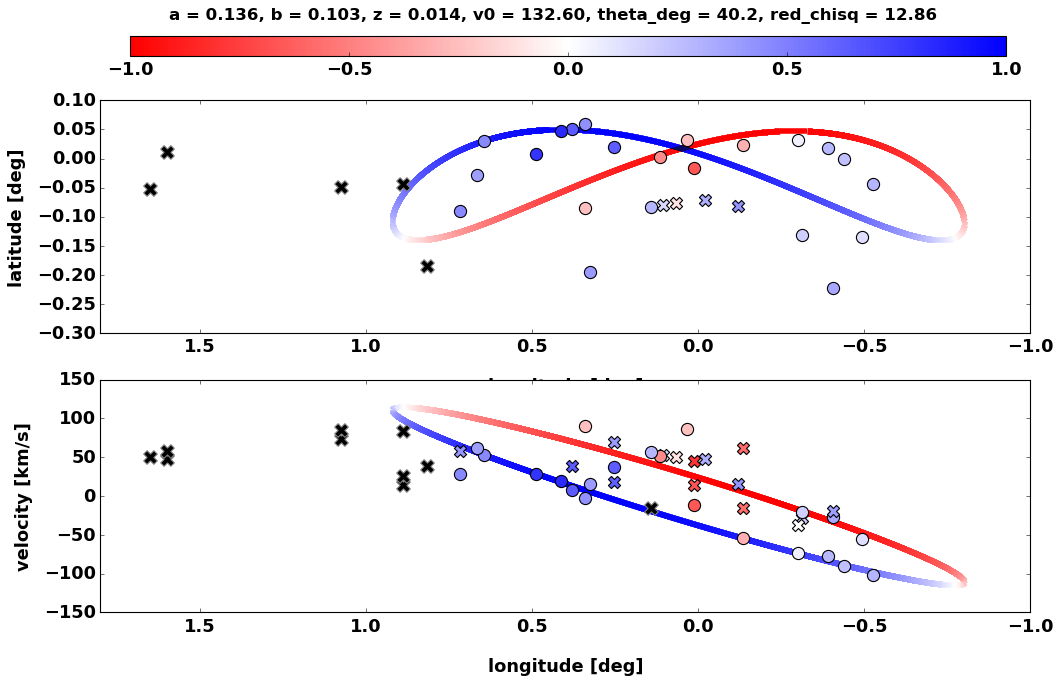

In [175]:
agrid = np.arange(10, 305, 5)
bgrid = np.arange(10, 305, 5)

grid_tab = Table()
r0, a_out, b_out, z_out, v_out, theta_out, redchisq = [], [], [], [], [], [],[]

for i in range(len(agrid)):
    print(agrid[i],bgrid[i])

    params_GRID = create_params(a_rings={'value': agrid[i]/1e3   , 'min': 0.01, 'max': 0.3, 'vary': True},
                               b_rings={'value': bgrid[i]/1e3  , 'min': 0.01, 'max': 0.2, 'vary': True},
                               z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                               v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                               theta_rings={'value': 25  , 'min': 15, 'max': 360, 'vary': True},
                               ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                                  )
    
    out = minimize(ring_resid, params_GRID, method='nelder', args=(Ndata.l0,Ndata.b0,Ndata.v0))
    
        
    #if (np.mean(Rings_out.vr[ring_NF_dist(Rings_out)[1]])<np.mean(Rings_out.vr[ring_NF_dist(Rings_out)[0]])):
    
    dphi = np.radians(0.001)
    phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)

    Rings_out = Ring(phi,
                      out.params['a_rings'].value,
                      out.params['b_rings'].value,
                      out.params['z_rings'].value,
                      out.params['v_rings'].value, 
                      np.radians(out.params['theta_rings'].value),
                      xyzsun,vxyzsun)


#    N_cent_vr = Rings_out.vr[argmedian(np.degrees(Rings_out.l[ring_NF_dist(Rings_out)[1][0]]))]
#    F_cent_vr = Rings_out.vr[argmedian(np.degrees(Rings_out.l[ring_NF_dist(Rings_out)[0][0]]))]
    NN = np.where(ring_NF_dist(Rings_out)[2]==1)
    FF = np.where(ring_NF_dist(Rings_out)[2]==-1)

    print(Rings_out.vr[NN], Rings_out.vr[FF])

    print(np.degrees(Rings_out.l[NN]), np.degrees(Rings_out.l[FF]) , ring_NF_dist(Rings_out)[2][NN], ring_NF_dist(Rings_out)[2][FF])

#    N_rings_arr = Rings_out.l[ring_NF_dist(Rings_out)[1][0]]
#    N_cent_vr = Rings_out.vr[argmedian(N_rings_arr[np.where((np.degrees(N_rings_arr)>0) )[0]])]

#    F_rings_arr = Rings_out.l[ring_NF_dist(Rings_out)[0][0]]
#    F_cent_vr = Rings_out.vr[argmedian(F_rings_arr[np.where((np.degrees(F_rings_arr)>0.) )[0]])]
    if (Rings_out.vr[NN]<Rings_out.vr[FF]):
        lb_lv_plots_postcolor_grad(Rings_out, out)
        
        r0.append(agrid[i])
        a_out.append(out.params['a_rings'].value)
        b_out.append(out.params['b_rings'].value)
        z_out.append(out.params['z_rings'].value)
        v_out.append(out.params['v_rings'].value)
        theta_out.append(out.params['theta_rings'].value)
        redchisq.append(out.redchi)

In [173]:
#N_cent_vr = Rings_out.vr[np.argmin(abs(Rings_out.l[ring_NF_dist(Rings_out)[1][0]]))]
#F_cent_vr = Rings_out.vr[np.argmin(abs(Rings_out.l[ring_NF_dist(Rings_out)[0][0]]))]
NN = np.where(ring_NF_dist(Rings_out)[2]==1)
FF = np.where(ring_NF_dist(Rings_out)[2]==-1)

print(Rings_out.vr[NN], Rings_out.vr[FF])
np.degrees(Rings_out.l[NN]), np.degrees(Rings_out.l[FF]), ring_NF_dist(Rings_out)[2][NN], ring_NF_dist(Rings_out)[2][FF]

[-0.00129442] [-0.02049355]


(array([-0.17797083]), array([0.2909941]), array([1.]), array([-1.]))

In [149]:
Rings_out.vr[np.argmin(ring_NF_dist(Rings_out)[2])], Rings_out.vr[np.argmin(ring_NF_dist(Rings_out)[2])]
ring_NF_dist(Rings_out)[0][0]

array([     0,      1,      2, ..., 359997, 359998, 359999],
      shape=(180927,))

Text(0.5, 0, 'redchisq')

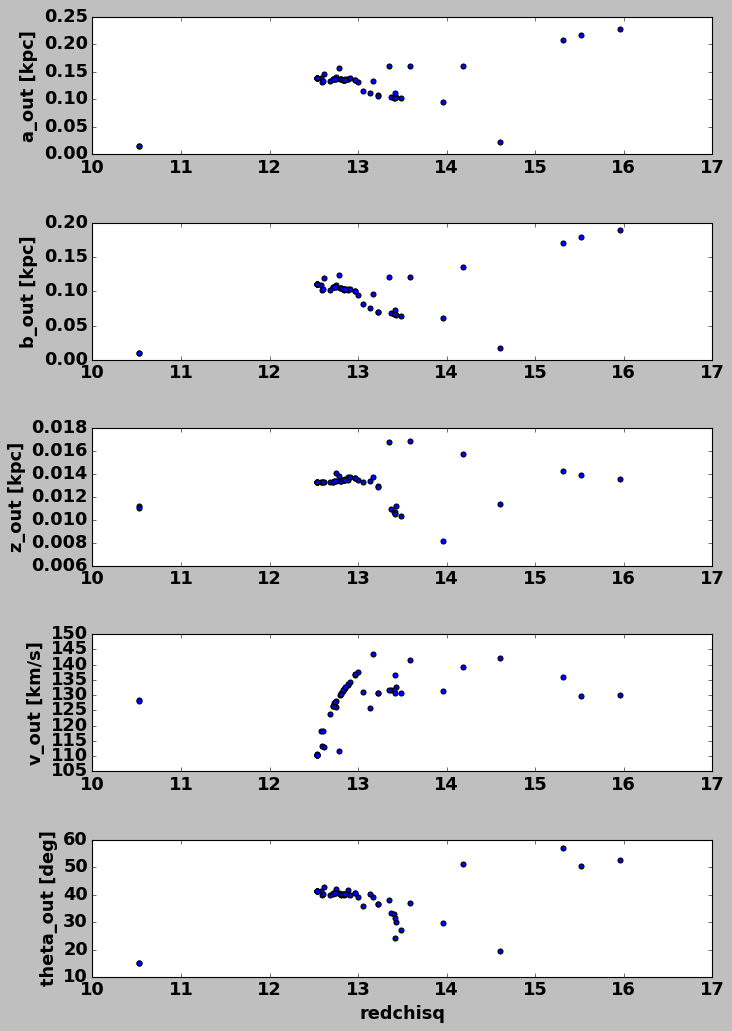

In [ ]:



plt.subplots_adjust(hspace=0.5)
ax[0].scatter(redchisq, a_out)
ax[1].scatter(redchisq, b_out)
ax[2].scatter(redchisq, z_out)
ax[3].scatter(redchisq, v_out)
ax[4].scatter(redchisq, theta_out)

ax[0].set_ylabel('a_out [kpc]')
ax[1].set_ylabel('b_out [kpc]')
ax[2].set_ylabel('z_out [kpc]')
ax[3].set_ylabel('v_out [km/s]')
ax[4].set_ylabel('theta_out [deg]')
ax[4].set_xlabel('redchisq')



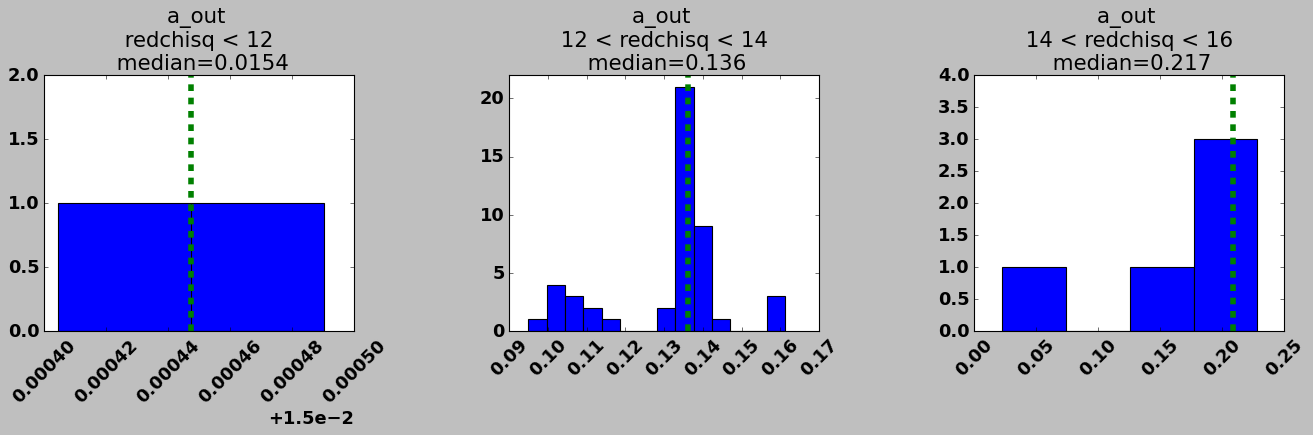

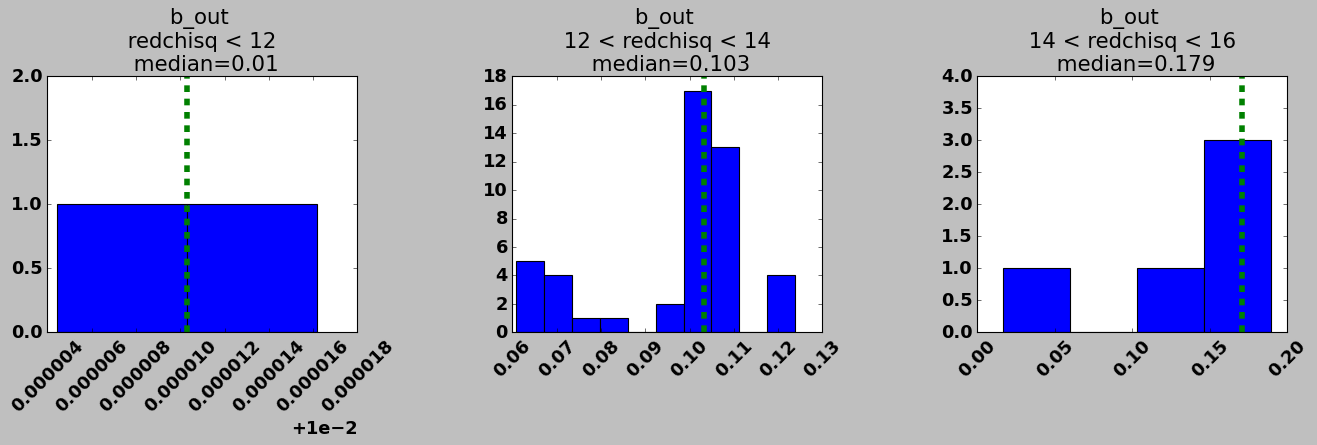

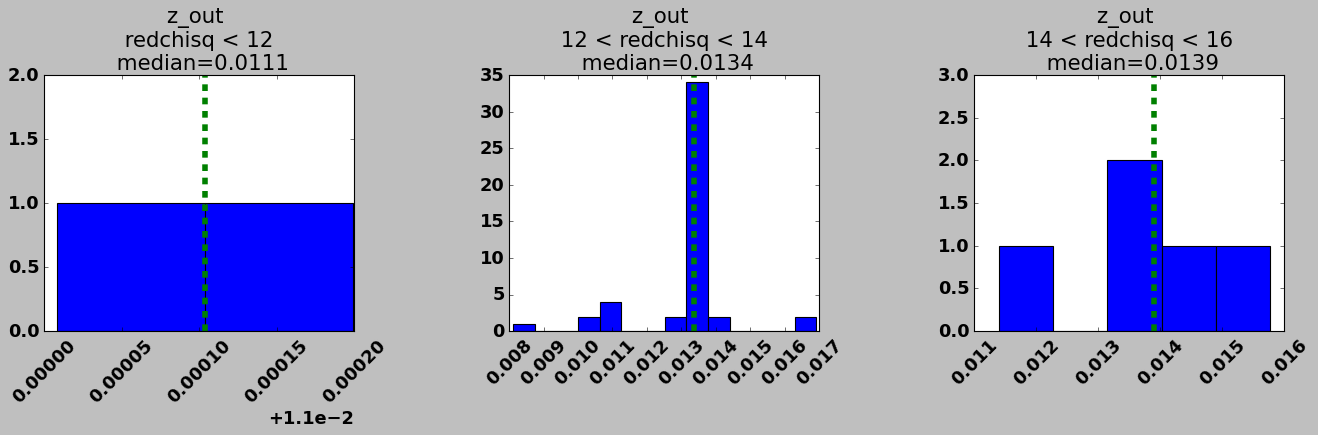

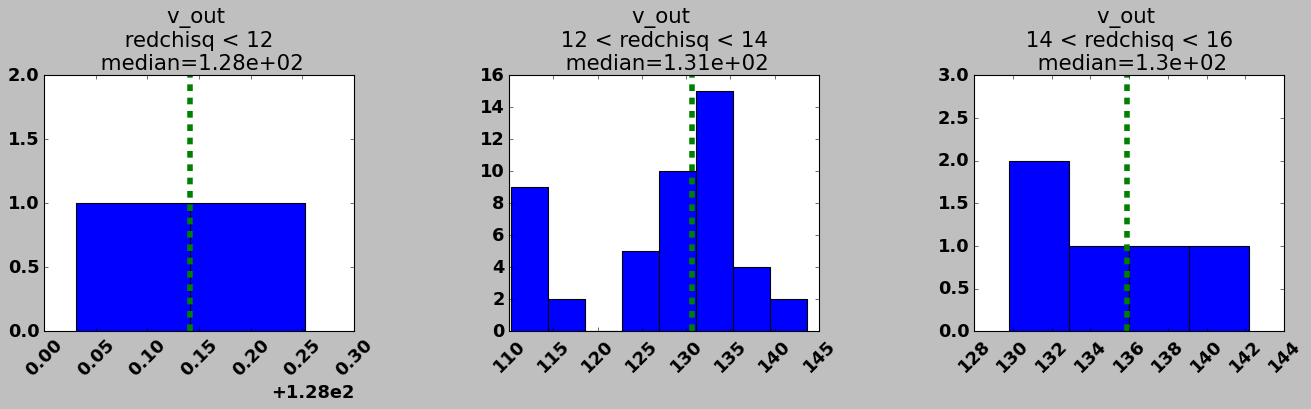

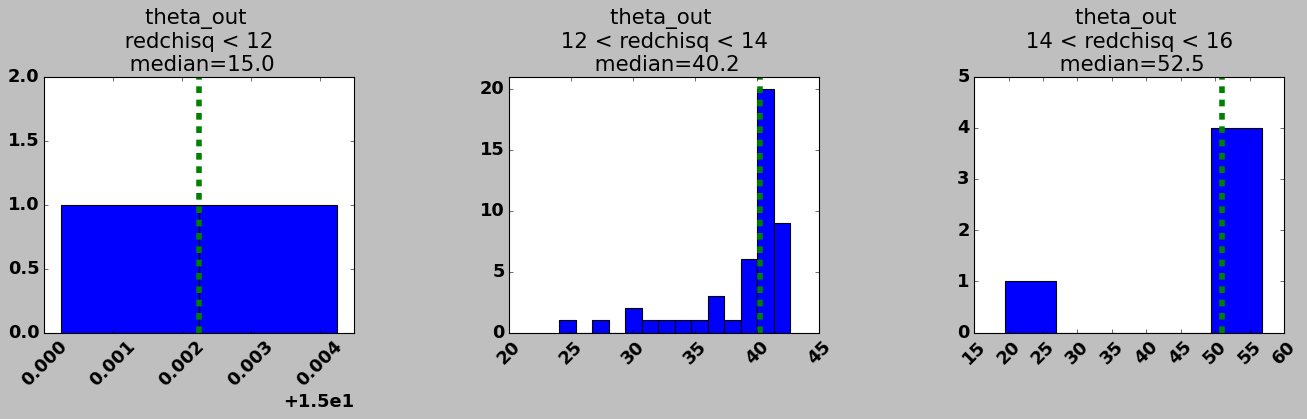

In [ ]:
#find the average values between redchisq of 10-11, 12-13, 13-14, and again for 15-16 where clusters appear
    

output_params = [a_out, b_out, z_out, v_out, theta_out]
output_param_name = ['a_out','b_out','z_out','v_out', 'theta_out']
for i in range(len(output_params)):

    fig, ax = plt.subplots(1, 3,  figsize=(20, 4))
    plt.subplots_adjust(wspace=0.5)

    lower_bin = np.asarray(redchisq)<=12
    h = ax[0].hist(np.asarray(output_params[i])[lower_bin], bins='auto')
    ax[0].axvline(np.median(np.asarray(output_params[i])[lower_bin]), color='g', linestyle='dashed', linewidth=5)
    ax[0].set_ylim(0,h[0].max()+1)
    ax[0].set_title('{} \n 10 < redchisq < 12 \n median={:.3}'.format(str(output_param_name[i]), np.median(np.asarray(output_params[i])[lower_bin])))
    ax[0].tick_params(axis='x', labelrotation=45)

    bin_12_14 = (np.asarray(redchisq)<=14) & (np.asarray(redchisq)>12)
    h = ax[1].hist(np.asarray(output_params[i])[bin_12_14], bins='auto')
    ax[1].axvline(np.median(np.asarray(output_params[i])[bin_12_14]), color='g', linestyle='dashed', linewidth=5)
    ax[1].set_ylim(0,h[0].max()+1)
    ax[1].set_title('{} \n 12 < redchisq < 14 \n median={:.3}'.format(str(output_param_name[i]),np.median(np.asarray(output_params[i])[bin_12_14])))
    ax[1].tick_params(axis='x', labelrotation=45)

    bin_14_16 = (np.asarray(redchisq)<=16) & (np.asarray(redchisq)>14)
    h = ax[2].hist(np.asarray(output_params[i])[bin_14_16], bins='auto')
    ax[2].axvline(np.median(np.asarray(output_params[i])[bin_14_16]), color='g', linestyle='dashed', linewidth=5)
    ax[2].set_ylim(0,h[0].max()+1)
    ax[2].set_title('{} \n 14 < redchisq < 16 \n median={:.3}'.format(str(output_param_name[i]),np.median(np.asarray(output_params[i])[bin_15_16])))
    ax[2].tick_params(axis='x', labelrotation=45)





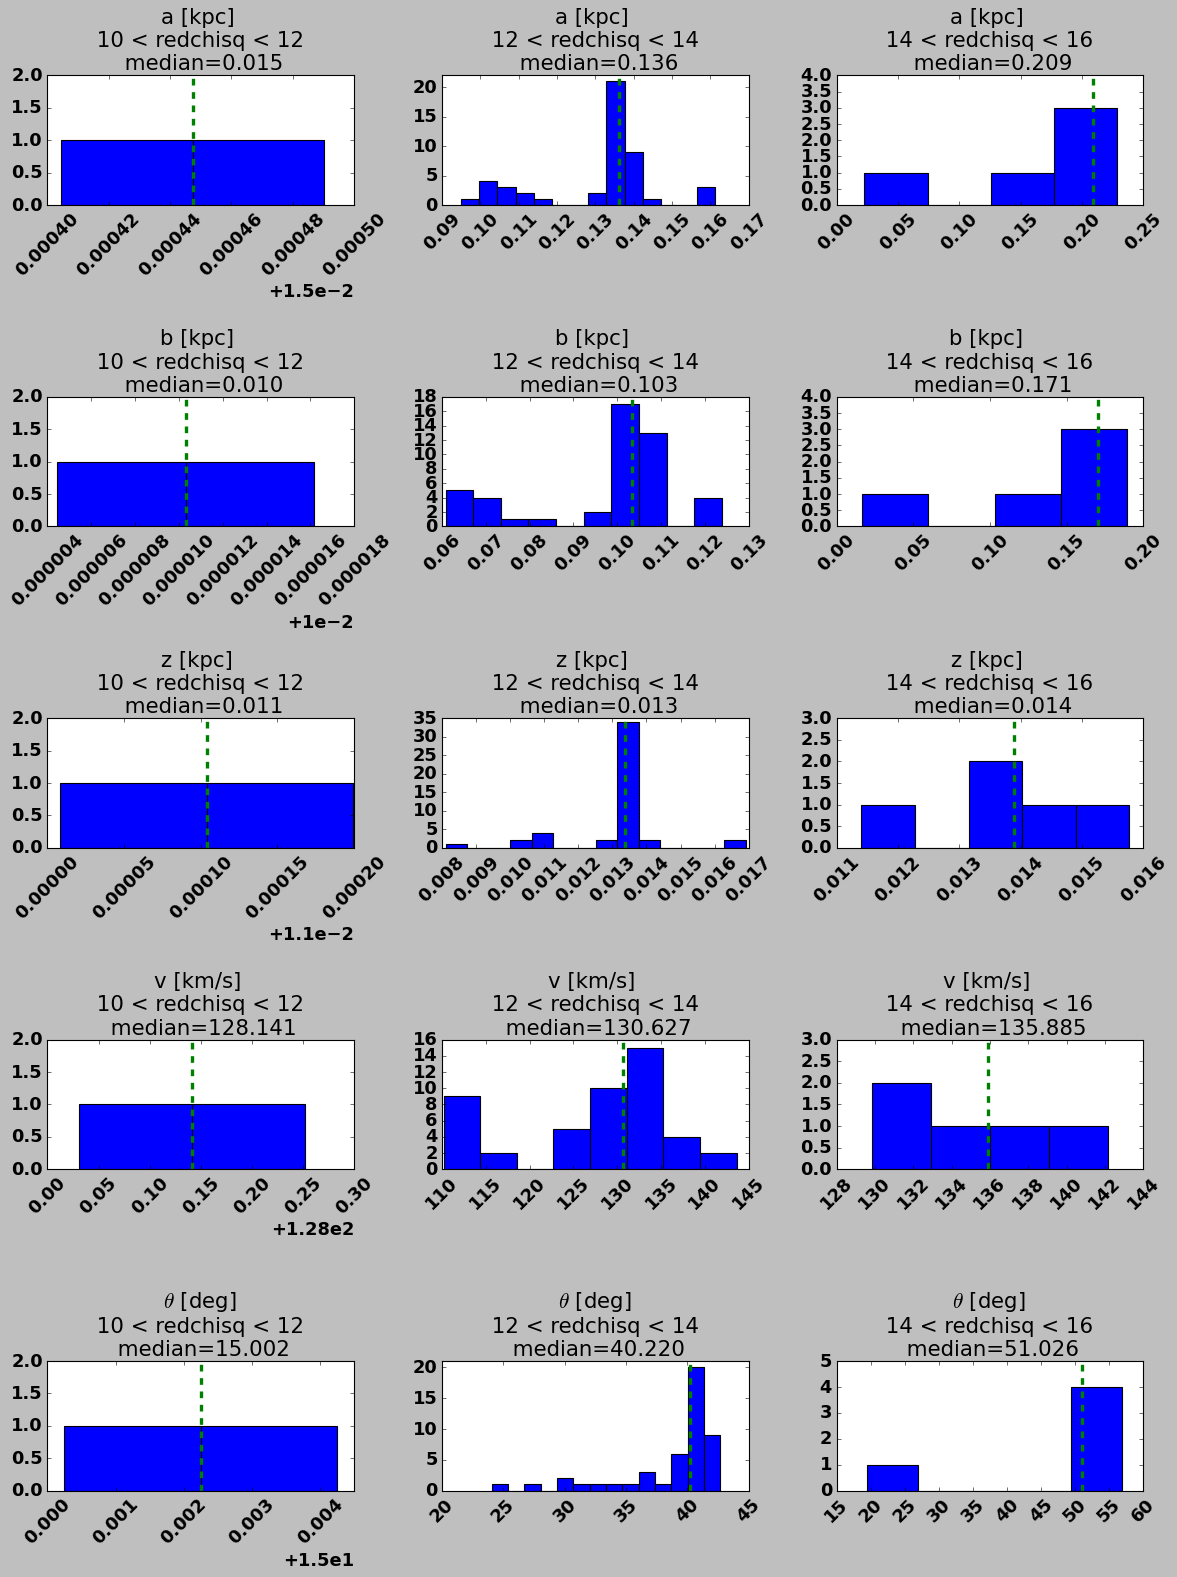

In [351]:
# Create a single 5x3 grid of subplots
fig, axs = plt.subplots(5, 3, figsize=(15, 20))  # 5 rows (params), 3 cols (bins)
plt.subplots_adjust(wspace=0.4, hspace=0.2)

output_params = [a_out, b_out, z_out, v_out, theta_out]
output_param_name = ['a [kpc]', 'b [kpc]', 'z [kpc]', 'v [km/s]', r'$\theta$ [deg]']

# Define redchisq bin masks
redchisq = np.asarray(redchisq)  # ensure it's a NumPy array
bins = [
    (redchisq <= 12),                          # 10–12
    (redchisq > 12) & (redchisq <= 14),        # 12–14
    (redchisq > 14) & (redchisq <= 16)         # 14–16
]
bin_labels = [
    '10 < redchisq < 12',
    '12 < redchisq < 14',
    '14 < redchisq < 16'
]

# Loop through each parameter (rows)
for i in range(len(output_params)):
    param_array = np.asarray(output_params[i])
    
    # Loop through each redchisq bin (columns)
    for j in range(3):
        ax = axs[i, j]
        mask = bins[j]
        hist_vals = param_array[mask]
        
        h = ax.hist(hist_vals, bins='auto')
        median_val = np.median(hist_vals)
        
        ax.axvline(median_val, color='g', linestyle='dashed', linewidth=3)
        ax.set_ylim(0, h[0].max() + 1)
        ax.set_title(f'{output_param_name[i]} \n {bin_labels[j]} \n median={median_val:.3f}')
        ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.savefig('./paper_items/Figs/redchisq_converge.pdf', bbox_inches='tight')

In [239]:
str(output)

'[np.float64(0.015404475138727407), np.float64(0.01549031882294138), np.float64(0.02274762675574269), np.float64(0.13898284227586538), np.float64(0.13167879153970705), np.float64(0.09499448260222942), np.float64(0.13543269258999507), np.float64(0.10331460459708092), np.float64(0.101759311873056), np.float64(0.10507681305883698), np.float64(0.10247836845105478), np.float64(0.10238770534847136), np.float64(0.10706836651253386), np.float64(0.10661328285899431), np.float64(0.11543772128656596), np.float64(0.13842812074295655), np.float64(0.13816182623217932), np.float64(0.13817655258776967), np.float64(0.1316425672911466), np.float64(0.1463503239623502), np.float64(0.1405746261764092), np.float64(0.13795972252467814), np.float64(0.13329971854297185), np.float64(0.13367222157515937), np.float64(0.15783668805107995), np.float64(0.13797829399903633), np.float64(0.13595920673259695), np.float64(0.13596140885414384), np.float64(0.13686823451813523), np.float64(0.13584600294564791), np.float64(0